In [2]:
%load_ext autoreload
%autoreload 2

import pickle
import lib.fd_imputer as fd_imputer
import pandas as pd
import numpy as np
from sklearn import metrics
import itertools
import matplotlib.pyplot as plt
from computer import compute_fd_imputer

In [3]:
from constants import NURSERY as N

## Load data, make definitions

In [4]:
df_train, df_validate, df_test = fd_imputer.load_dataframes(N.splits_path, NURSERY.title, np.nan)
fds = fd_imputer.read_fds(N.fd_path)

## FD_Imputer on adult.csv

In [6]:
fd_imputer_results = compute_fd_imputer(N, save=False)

0 duplicates detected in the splittings.
{2: [[0]], 9: [[0], [1, 2, 3, 4, 5, 6, 7, 8]], 3: [[0]], 4: [[0]], 1: [[0]], 5: [[0]], 7: [[0]], 8: [[0]], 6: [[0]], 0: [[1, 2, 3, 4, 5, 6, 7, 8]]}
{2: [0]}


IndexError: positional indexers are out-of-bounds

In [7]:
debug

> /home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/indexing.py(2081)_validate_key()
   2079 
   2080             if len(arr) and (arr.max() >= len_axis or arr.min() < -len_axis):
-> 2081                 raise IndexError("positional indexers are out-of-bounds")
   2082         else:
   2083             raise ValueError("Can only index by location with "

ipdb> up
> /home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/indexing.py(223)_has_valid_tuple()
    221                 raise IndexingError('Too many indexers')
    222             try:
--> 223                 self._validate_key(k, i)
    224             except ValueError:
    225                 raise ValueError("Location based indexing can only have "

ipdb> up
> /home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/indexing.py(2143)_getitem_tuple()
   2141     def _getitem_tuple(self, tup):
   2142 
-> 2143         self._has_valid_tuple(tup)
   2144         tr

## ML imputation on fd's

In [ ]:
ml_imputer_results = fd_imputer.run_ml_imputer_on_fd_set(df_train,
                                                        df_validate,
                                                        df_test,
                                                        fds,
                                                        continuous)

In [43]:
# this took forever, so better pickle the result
import pickle
# pickle.dump(ml_imputer_results, open( "adult_ml_results.p", "wb"))
ml_imputer_results = pickle.load(open("adult_ml_results.p", "rb"))

## Plot f1 scores

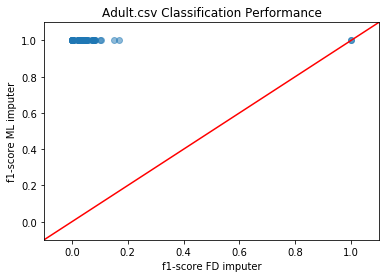

In [12]:
f1_fd = [y['f1'] for x in fd_imputer_results for y in fd_imputer_results[x] if 'f1' in y.keys()]
f1_ml = [y['f1'] for x in ml_imputer_results for y in ml_imputer_results[x] if 'f1' in y.keys()]
fig, ax = plt.subplots()
sc = plt.scatter(f1_fd, 
                 f1_ml, 
                 alpha=0.5)
plt.plot(np.linspace(-2, 2), np.linspace(-2, 2), c='red')
ax.set(title='Adult.csv Classification Performance',
      xlabel = 'f1-score FD imputer',
      ylabel = 'f1-score ML imputer',
      xlim = [-0.1, 1.1],
      ylim  = [-0.1, 1.1])
fig.savefig('figures/ml-fd-classification.png', transparent=False,
           dpi=320, bbox_inches='tight')

## Plot MSE

In [50]:
mse_fd = [y['mse'] for x in fd_imputer_results for y in fd_imputer_results[x] if 'mse' in y.keys()]
mse_ml = [y['mse'] for x in ml_imputer_results for y in ml_imputer_results[x] if 'mse' in y.keys()]

In [51]:
rel_mse = []
for i, x in enumerate(mse_fd):
    if x != '':
        rel_mse.append(mse_fd[i]/mse_ml[i])
    else:
        rel_mse.append(np.nan)

[Text(0, 0.5, 'mse_fd / mse_ml'),
 (-0.1, 11),
 Text(0.5, 0, 'FD LHS combination'),
 Text(0.5, 1.0, 'Adult.csv Mean Squared Error of two imputers')]

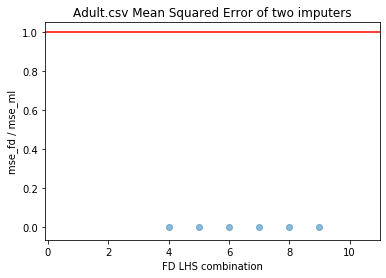

In [52]:
fig, ax = plt.subplots()
sc = plt.scatter(list(range(0, len(rel_mse))), 
                 rel_mse,
                 alpha=0.5)
plt.plot(np.linspace(-2, len(rel_mse)), [1]*50, c='red')
ax.set(title='Adult.csv Mean Squared Error of two imputers',
      xlabel = 'FD LHS combination',
      ylabel = 'mse_fd / mse_ml',
      xlim = [-0.1, 11])

Hier sind alle MSEs des fd_imputers 0, falls es sie ueberhaupt gibt. Macht so auch Sinn, dadurch, dass FDs nur kategorisch klassifizieren, sollte kein Fehler möglich sein.

Falls mse_fd / mse_ml > 1 ist, ist mse_ml kleiner als mse_fd um den Faktor, den man auf der y-Achse ablesen kann.
Generell ist diese Darstellung dubios, ich sollte die MSE lieber in einer Tabelle auffuehren.

## Overfitting the ML imputer

In [28]:
overfitted_ml_imputer_results = fd_imputer.run_ml_imputer_on_fd_set(
                                                        pd.concat([df_train, df_validate]),
                                                        pd.concat([df_train, df_validate]),
                                                        df_test,
                                                        fds,
                                                        continuous)

[0] 3


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-07-03 22:44:55,949 [INFO]  
========== start: fit model
2019-07-03 22:44:55,950 [WARNING]  Already bound, ignoring bind()
2019-07-03 22:44:56,916 [INFO]  Epoch[0] Batch [0-916]	Speed: 15287.36 samples/sec	cross-entropy=0.034330	3-accuracy=0.000000
2019-07-03 22:44:57,847 [INFO]  Epoch[0] Train-cross-entropy=0.022534
2019-07-03 22:44:57,849 [INFO]  Epoch[0] Train-3-accuracy=0.000000
2019-07-03 22:44:57,850 [INFO]  Epoch[0] Time cost=1.896
2019-07-03 22:44:57,854 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-03 22:44:58,584 [INFO]  Epoch[0] Validation-cross-entropy=0.000920
2019-07

[0] 11


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-07-03 22:45:25,635 [INFO]  
========== start: fit model
2019-07-03 22:45:25,636 [WARNING]  Already bound, ignoring bind()
2019-07-03 22:45:26,534 [INFO]  Epoch[0] Batch [0-916]	Speed: 16456.38 samples/sec	cross-entropy=0.295282	11-accuracy=0.000000
2019-07-03 22:45:27,433 [INFO]  Epoch[0] Train-cross-entropy=0.231485
2019-07-03 22:45:27,434 [INFO]  Epoch[0] Train-11-accuracy=0.000000
2019-07-03 22:45:27,435 [INFO]  Epoch[0] Time cost=1.794
2019-07-03 22:45:27,441 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-03 22:45:28,124 [INFO]  Epoch[0] Validation-cross-entropy=0.000239
2019-

[0] 13


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-07-03 22:45:53,480 [INFO]  
========== start: fit model
2019-07-03 22:45:53,481 [WARNING]  Already bound, ignoring bind()
2019-07-03 22:45:54,400 [INFO]  Epoch[0] Batch [0-916]	Speed: 16078.38 samples/sec	cross-entropy=0.360265	13-accuracy=0.000000
2019-07-03 22:45:55,291 [INFO]  Epoch[0] Train-cross-entropy=0.180563
2019-07-03 22:45:55,292 [INFO]  Epoch[0] Train-13-accuracy=0.000000
2019-07-03 22:45:55,294 [INFO]  Epoch[0] Time cost=1.808
2019-07-03 22:45:55,297 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-03 22:45:55,994 [INFO]  Epoch[0] Validation-cross-entropy=0.000262
2019-

[0] 12


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-07-03 22:46:08,587 [INFO]  
========== start: fit model
2019-07-03 22:46:08,589 [WARNING]  Already bound, ignoring bind()
2019-07-03 22:46:09,512 [INFO]  Epoch[0] Batch [0-916]	Speed: 15979.44 samples/sec	cross-entropy=0.045399	12-accuracy=0.000000
2019-07-03 22:46:10,398 [INFO]  Epoch[0] Train-cross-entropy=0.056235
2019-07-03 22:46:10,399 [INFO]  Epoch[0] Train-12-accuracy=0.000000
2019-07-03 22:46:10,400 [INFO]  Epoch[0] Time cost=1.808
2019-07-03 22:46:10,404 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-03 22:46:11,112 [INFO]  Epoch[0] Validation-cross-entropy=0.405974
2019-

[13, 1, 2, 3, 4, 7] 12


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-07-03 22:46:32,225 [INFO]  
========== start: fit model
2019-07-03 22:46:32,226 [WARNING]  Already bound, ignoring bind()
2019-07-03 22:46:40,234 [INFO]  Epoch[0] Batch [0-916]	Speed: 1834.15 samples/sec	cross-entropy=0.126259	12-accuracy=0.000000
2019-07-03 22:46:48,166 [INFO]  Epoch[0] Train-cross-entropy=0.079503
2019-07-03 22:46:48,167 [INFO]  Epoch[0] Train-12-accuracy=0.000000
2019-07-03 22:46:48,168 [INFO]  Epoch[0] Time cost=15.938
2019-07-03 22:46:48,173 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-03 22:47:01,602 [INFO]  Epoch[0] Validation-cross-entropy=0.214061
2019-

[13, 1, 3, 4, 6, 7] 12


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-07-03 22:52:13,848 [INFO]  
========== start: fit model
2019-07-03 22:52:13,850 [WARNING]  Already bound, ignoring bind()
2019-07-03 22:52:21,764 [INFO]  Epoch[0] Batch [0-916]	Speed: 1856.17 samples/sec	cross-entropy=0.130425	12-accuracy=0.000000
2019-07-03 22:52:29,599 [INFO]  Epoch[0] Train-cross-entropy=0.075047
2019-07-03 22:52:29,600 [INFO]  Epoch[0] Train-12-accuracy=0.000000
2019-07-03 22:52:29,602 [INFO]  Epoch[0] Time cost=15.747
2019-07-03 22:52:29,607 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-03 22:52:42,977 [INFO]  Epoch[0] Validation-cross-entropy=0.193610
2019-

[13, 1, 3, 4, 7, 8] 12


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-07-03 22:56:26,627 [INFO]  
========== start: fit model
2019-07-03 22:56:26,629 [WARNING]  Already bound, ignoring bind()
2019-07-03 22:56:34,681 [INFO]  Epoch[0] Batch [0-916]	Speed: 1823.09 samples/sec	cross-entropy=0.125744	12-accuracy=0.000000
2019-07-03 22:56:42,636 [INFO]  Epoch[0] Train-cross-entropy=0.088024
2019-07-03 22:56:42,637 [INFO]  Epoch[0] Train-12-accuracy=0.000000
2019-07-03 22:56:42,639 [INFO]  Epoch[0] Time cost=16.006
2019-07-03 22:56:42,644 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-03 22:56:55,825 [INFO]  Epoch[0] Validation-cross-entropy=0.131667
2019-

[13, 1, 2, 3, 5, 7] 12


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-07-03 23:01:06,849 [INFO]  
========== start: fit model
2019-07-03 23:01:06,852 [WARNING]  Already bound, ignoring bind()
2019-07-03 23:01:14,813 [INFO]  Epoch[0] Batch [0-916]	Speed: 1844.20 samples/sec	cross-entropy=0.123857	12-accuracy=0.000000
2019-07-03 23:01:22,598 [INFO]  Epoch[0] Train-cross-entropy=0.084116
2019-07-03 23:01:22,599 [INFO]  Epoch[0] Train-12-accuracy=0.000000
2019-07-03 23:01:22,601 [INFO]  Epoch[0] Time cost=15.745
2019-07-03 23:01:22,608 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-03 23:01:36,281 [INFO]  Epoch[0] Validation-cross-entropy=0.100395
2019-

[13, 1, 3, 5, 6, 7] 12


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-07-03 23:05:26,415 [INFO]  
========== start: fit model
2019-07-03 23:05:26,418 [WARNING]  Already bound, ignoring bind()
2019-07-03 23:05:35,682 [INFO]  Epoch[0] Batch [0-916]	Speed: 1584.72 samples/sec	cross-entropy=0.144994	12-accuracy=0.000000
2019-07-03 23:05:45,122 [INFO]  Epoch[0] Train-cross-entropy=0.090172
2019-07-03 23:05:45,125 [INFO]  Epoch[0] Train-12-accuracy=0.000000
2019-07-03 23:05:45,129 [INFO]  Epoch[0] Time cost=18.707
2019-07-03 23:05:45,134 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-03 23:06:03,492 [INFO]  Epoch[0] Validation-cross-entropy=0.154589
2019-

[13, 1, 3, 5, 7, 8] 12


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-07-03 23:10:05,490 [INFO]  
========== start: fit model
2019-07-03 23:10:05,492 [WARNING]  Already bound, ignoring bind()
2019-07-03 23:10:14,217 [INFO]  Epoch[0] Batch [0-916]	Speed: 1682.37 samples/sec	cross-entropy=0.166938	12-accuracy=0.000000
2019-07-03 23:10:23,090 [INFO]  Epoch[0] Train-cross-entropy=0.093998
2019-07-03 23:10:23,093 [INFO]  Epoch[0] Train-12-accuracy=0.000000
2019-07-03 23:10:23,094 [INFO]  Epoch[0] Time cost=17.599
2019-07-03 23:10:23,205 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-03 23:10:37,638 [INFO]  Epoch[0] Validation-cross-entropy=0.009518
2019-

[0] 1


/home/philipp/code/python-envs/mlfd/lib/python3.7/site-packages/pandas/core/frame.py:3391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
2019-07-03 23:15:52,833 [INFO]  
========== start: fit model
2019-07-03 23:15:52,839 [WARNING]  Already bound, ignoring bind()
2019-07-03 23:15:53,750 [INFO]  Epoch[0] Batch [0-916]	Speed: 16175.58 samples/sec	cross-entropy=0.037748	1-accuracy=0.000000
2019-07-03 23:15:54,610 [INFO]  Epoch[0] Train-cross-entropy=0.022797
2019-07-03 23:15:54,612 [INFO]  Epoch[0] Train-1-accuracy=0.000000
2019-07-03 23:15:54,614 [INFO]  Epoch[0] Time cost=1.772
2019-07-03 23:15:54,619 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-03 23:15:55,283 [INFO]  Epoch[0] Validation-cross-entropy=0.000300
2019-07

[0] 14


2019-07-03 23:16:09,356 [INFO]  
========== start: fit model
2019-07-03 23:16:09,357 [WARNING]  Already bound, ignoring bind()
2019-07-03 23:16:30,042 [INFO]  Epoch[0] Batch [0-916]	Speed: 710.03 samples/sec	cross-entropy=0.225750	14-accuracy=0.960810
2019-07-03 23:16:50,603 [INFO]  Epoch[0] Train-cross-entropy=0.123675
2019-07-03 23:16:50,604 [INFO]  Epoch[0] Train-14-accuracy=0.979735
2019-07-03 23:16:50,607 [INFO]  Epoch[0] Time cost=41.247
2019-07-03 23:16:50,623 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-03 23:17:08,001 [INFO]  Epoch[0] Validation-cross-entropy=0.008218
2019-07-03 23:17:08,003 [INFO]  Epoch[0] Validation-14-accuracy=0.999932
2019-07-03 23:17:28,616 [INFO]  Epoch[1] Batch [0-916]	Speed: 711.86 samples/sec	cross-entropy=0.005286	14-accuracy=1.000000
2019-07-03 23:17:49,067 [INFO]  Epoch[1] Train-cross-entropy=0.003951
2019-07-03 23:17:49,070 [INFO]  Epoch[1] Train-14-accuracy=0.999966
2019-07-03 23:17:49,073 [INFO]  Epoch[1] Time cost=41.0

[0] 4


2019-07-03 23:26:49,803 [INFO]  
========== start: fit model
2019-07-03 23:26:49,805 [WARNING]  Already bound, ignoring bind()
2019-07-03 23:27:02,822 [INFO]  Epoch[0] Batch [0-916]	Speed: 1128.18 samples/sec	cross-entropy=0.245413	4-accuracy=0.966262
2019-07-03 23:27:15,841 [INFO]  Epoch[0] Train-cross-entropy=0.128416
2019-07-03 23:27:16,154 [INFO]  Epoch[0] Train-4-accuracy=0.983113
2019-07-03 23:27:16,159 [INFO]  Epoch[0] Time cost=26.350
2019-07-03 23:27:16,175 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-03 23:27:30,957 [INFO]  Epoch[0] Validation-cross-entropy=0.005852
2019-07-03 23:27:30,959 [INFO]  Epoch[0] Validation-4-accuracy=1.000000
2019-07-03 23:27:43,776 [INFO]  Epoch[1] Batch [0-916]	Speed: 1145.32 samples/sec	cross-entropy=0.003928	4-accuracy=1.000000
2019-07-03 23:27:56,603 [INFO]  Epoch[1] Train-cross-entropy=0.002903
2019-07-03 23:27:56,604 [INFO]  Epoch[1] Train-4-accuracy=1.000000
2019-07-03 23:27:56,607 [INFO]  Epoch[1] Time cost=25.646


[5] 4


2019-07-03 23:34:24,926 [INFO]  
========== start: fit model
2019-07-03 23:34:24,927 [WARNING]  Already bound, ignoring bind()
2019-07-03 23:34:37,808 [INFO]  Epoch[0] Batch [0-916]	Speed: 1139.98 samples/sec	cross-entropy=0.160636	4-accuracy=0.979417
2019-07-03 23:34:50,552 [INFO]  Epoch[0] Train-cross-entropy=0.083039
2019-07-03 23:34:50,555 [INFO]  Epoch[0] Train-4-accuracy=0.989697
2019-07-03 23:34:50,557 [INFO]  Epoch[0] Time cost=25.626
2019-07-03 23:34:50,565 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-03 23:35:05,846 [INFO]  Epoch[0] Validation-cross-entropy=0.002680
2019-07-03 23:35:05,848 [INFO]  Epoch[0] Validation-4-accuracy=1.000000
2019-07-03 23:35:18,710 [INFO]  Epoch[1] Batch [0-916]	Speed: 1140.89 samples/sec	cross-entropy=0.001794	4-accuracy=1.000000
2019-07-03 23:35:31,575 [INFO]  Epoch[1] Train-cross-entropy=0.001319
2019-07-03 23:35:31,577 [INFO]  Epoch[1] Train-4-accuracy=1.000000
2019-07-03 23:35:31,579 [INFO]  Epoch[1] Time cost=25.729


[0] 5


2019-07-03 23:42:01,564 [INFO]  
========== start: fit model
2019-07-03 23:42:01,566 [WARNING]  Already bound, ignoring bind()
2019-07-03 23:42:14,592 [INFO]  Epoch[0] Batch [0-916]	Speed: 1127.74 samples/sec	cross-entropy=0.711833	5-accuracy=0.857347
2019-07-03 23:42:27,325 [INFO]  Epoch[0] Train-cross-entropy=0.409094
2019-07-03 23:42:27,326 [INFO]  Epoch[0] Train-5-accuracy=0.926003
2019-07-03 23:42:27,329 [INFO]  Epoch[0] Time cost=25.761
2019-07-03 23:42:27,337 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-03 23:42:42,164 [INFO]  Epoch[0] Validation-cross-entropy=0.057160
2019-07-03 23:42:42,165 [INFO]  Epoch[0] Validation-5-accuracy=0.998465
2019-07-03 23:42:54,940 [INFO]  Epoch[1] Batch [0-916]	Speed: 1148.78 samples/sec	cross-entropy=0.039619	5-accuracy=0.998160
2019-07-03 23:43:07,894 [INFO]  Epoch[1] Train-cross-entropy=0.029062
2019-07-03 23:43:07,895 [INFO]  Epoch[1] Train-5-accuracy=0.998465
2019-07-03 23:43:07,898 [INFO]  Epoch[1] Time cost=25.730


[4] 5


2019-07-03 23:49:37,151 [INFO]  
========== start: fit model
2019-07-03 23:49:37,153 [WARNING]  Already bound, ignoring bind()
2019-07-03 23:49:48,854 [INFO]  Epoch[0] Batch [0-916]	Speed: 1255.06 samples/sec	cross-entropy=0.204407	5-accuracy=0.991276
2019-07-03 23:50:00,537 [INFO]  Epoch[0] Train-cross-entropy=0.105906
2019-07-03 23:50:00,539 [INFO]  Epoch[0] Train-5-accuracy=0.995633
2019-07-03 23:50:00,541 [INFO]  Epoch[0] Time cost=23.384
2019-07-03 23:50:00,549 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-03 23:50:15,838 [INFO]  Epoch[0] Validation-cross-entropy=0.003849
2019-07-03 23:50:15,839 [INFO]  Epoch[0] Validation-5-accuracy=1.000000
2019-07-03 23:50:27,493 [INFO]  Epoch[1] Batch [0-916]	Speed: 1259.25 samples/sec	cross-entropy=0.002597	5-accuracy=1.000000
2019-07-03 23:50:39,167 [INFO]  Epoch[1] Train-cross-entropy=0.001918
2019-07-03 23:50:39,168 [INFO]  Epoch[1] Train-5-accuracy=1.000000
2019-07-03 23:50:39,170 [INFO]  Epoch[1] Time cost=23.330


[0] 7


2019-07-03 23:56:52,887 [INFO]  
========== start: fit model
2019-07-03 23:56:52,889 [WARNING]  Already bound, ignoring bind()
2019-07-03 23:57:05,510 [INFO]  Epoch[0] Batch [0-916]	Speed: 1163.92 samples/sec	cross-entropy=0.195179	7-accuracy=0.982756
2019-07-03 23:57:17,832 [INFO]  Epoch[0] Train-cross-entropy=0.101081
2019-07-03 23:57:17,834 [INFO]  Epoch[0] Train-7-accuracy=0.991266
2019-07-03 23:57:17,836 [INFO]  Epoch[0] Time cost=24.944
2019-07-03 23:57:18,227 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-03 23:57:32,955 [INFO]  Epoch[0] Validation-cross-entropy=0.003396
2019-07-03 23:57:32,957 [INFO]  Epoch[0] Validation-7-accuracy=0.999932
2019-07-03 23:57:45,361 [INFO]  Epoch[1] Batch [0-916]	Speed: 1183.46 samples/sec	cross-entropy=0.002365	7-accuracy=0.999932
2019-07-03 23:57:57,660 [INFO]  Epoch[1] Train-cross-entropy=0.001726
2019-07-03 23:57:57,662 [INFO]  Epoch[1] Train-7-accuracy=0.999966
2019-07-03 23:57:57,663 [INFO]  Epoch[1] Time cost=24.704


[0] 2


2019-07-04 00:04:14,699 [INFO]  
========== start: fit model
2019-07-04 00:04:14,701 [WARNING]  Already bound, ignoring bind()
2019-07-04 00:04:25,330 [INFO]  Epoch[0] Batch [0-916]	Speed: 1381.36 samples/sec	cross-entropy=0.117036	2-accuracy=0.979757
2019-07-04 00:04:35,883 [INFO]  Epoch[0] Train-cross-entropy=0.061433
2019-07-04 00:04:35,885 [INFO]  Epoch[0] Train-2-accuracy=0.989697
2019-07-04 00:04:35,886 [INFO]  Epoch[0] Time cost=21.181
2019-07-04 00:04:35,895 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 00:04:49,930 [INFO]  Epoch[0] Validation-cross-entropy=0.003298
2019-07-04 00:04:49,932 [INFO]  Epoch[0] Validation-2-accuracy=0.999693
2019-07-04 00:05:00,426 [INFO]  Epoch[1] Batch [0-916]	Speed: 1398.47 samples/sec	cross-entropy=0.002498	2-accuracy=0.999796
2019-07-04 00:05:11,327 [INFO]  Epoch[1] Train-cross-entropy=0.001703
2019-07-04 00:05:11,330 [INFO]  Epoch[1] Train-2-accuracy=0.999898
2019-07-04 00:05:11,332 [INFO]  Epoch[1] Time cost=21.398


[0] 6


2019-07-04 00:10:58,474 [INFO]  
========== start: fit model
2019-07-04 00:10:58,477 [WARNING]  Already bound, ignoring bind()
2019-07-04 00:11:08,479 [INFO]  Epoch[0] Batch [0-916]	Speed: 1467.87 samples/sec	cross-entropy=0.113181	6-accuracy=0.982143
2019-07-04 00:11:18,283 [INFO]  Epoch[0] Train-cross-entropy=0.059735
2019-07-04 00:11:18,285 [INFO]  Epoch[0] Train-6-accuracy=0.990789
2019-07-04 00:11:18,287 [INFO]  Epoch[0] Time cost=19.806
2019-07-04 00:11:18,394 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 00:11:32,119 [INFO]  Epoch[0] Validation-cross-entropy=0.003777
2019-07-04 00:11:32,122 [INFO]  Epoch[0] Validation-6-accuracy=0.999386
2019-07-04 00:11:42,007 [INFO]  Epoch[1] Batch [0-916]	Speed: 1484.64 samples/sec	cross-entropy=0.002574	6-accuracy=0.999591
2019-07-04 00:11:51,786 [INFO]  Epoch[1] Train-cross-entropy=0.001780
2019-07-04 00:11:51,788 [INFO]  Epoch[1] Train-6-accuracy=0.999795
2019-07-04 00:11:51,790 [INFO]  Epoch[1] Time cost=19.666


[11, 13, 1, 3, 7, 8] 6


2019-07-04 00:17:24,803 [INFO]  
========== start: fit model
2019-07-04 00:17:24,804 [WARNING]  Already bound, ignoring bind()
2019-07-04 00:17:34,723 [INFO]  Epoch[0] Batch [0-916]	Speed: 1480.14 samples/sec	cross-entropy=0.147519	6-accuracy=0.972533
2019-07-04 00:17:44,593 [INFO]  Epoch[0] Train-cross-entropy=0.080928
2019-07-04 00:17:44,595 [INFO]  Epoch[0] Train-6-accuracy=0.985774
2019-07-04 00:17:44,597 [INFO]  Epoch[0] Time cost=19.790
2019-07-04 00:17:44,603 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 00:17:58,669 [INFO]  Epoch[0] Validation-cross-entropy=0.007240
2019-07-04 00:17:58,670 [INFO]  Epoch[0] Validation-6-accuracy=0.999352
2019-07-04 00:18:08,752 [INFO]  Epoch[1] Batch [0-916]	Speed: 1455.82 samples/sec	cross-entropy=0.005227	6-accuracy=0.999455
2019-07-04 00:18:18,641 [INFO]  Epoch[1] Train-cross-entropy=0.004141
2019-07-04 00:18:18,642 [INFO]  Epoch[1] Train-6-accuracy=0.999488
2019-07-04 00:18:18,645 [INFO]  Epoch[1] Time cost=19.972


[13, 1, 3, 4, 7, 8] 6


2019-07-04 00:23:53,471 [INFO]  
========== start: fit model
2019-07-04 00:23:53,473 [WARNING]  Already bound, ignoring bind()
2019-07-04 00:24:03,810 [INFO]  Epoch[0] Batch [0-916]	Speed: 1420.15 samples/sec	cross-entropy=0.165744	6-accuracy=0.966739
2019-07-04 00:24:13,706 [INFO]  Epoch[0] Train-cross-entropy=0.090614
2019-07-04 00:24:13,708 [INFO]  Epoch[0] Train-6-accuracy=0.983044
2019-07-04 00:24:13,710 [INFO]  Epoch[0] Time cost=20.233
2019-07-04 00:24:13,715 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 00:24:27,434 [INFO]  Epoch[0] Validation-cross-entropy=0.008765
2019-07-04 00:24:27,436 [INFO]  Epoch[0] Validation-6-accuracy=0.999386
2019-07-04 00:24:37,350 [INFO]  Epoch[1] Batch [0-916]	Speed: 1480.23 samples/sec	cross-entropy=0.006528	6-accuracy=0.999387
2019-07-04 00:24:47,209 [INFO]  Epoch[1] Train-cross-entropy=0.005170
2019-07-04 00:24:47,211 [INFO]  Epoch[1] Train-6-accuracy=0.999420
2019-07-04 00:24:47,213 [INFO]  Epoch[1] Time cost=19.775


[13, 1, 3, 5, 7, 8] 6


2019-07-04 00:30:21,160 [INFO]  
========== start: fit model
2019-07-04 00:30:21,163 [WARNING]  Already bound, ignoring bind()
2019-07-04 00:30:31,301 [INFO]  Epoch[0] Batch [0-916]	Speed: 1448.24 samples/sec	cross-entropy=0.146065	6-accuracy=0.971170
2019-07-04 00:30:41,244 [INFO]  Epoch[0] Train-cross-entropy=0.079375
2019-07-04 00:30:41,246 [INFO]  Epoch[0] Train-6-accuracy=0.985296
2019-07-04 00:30:41,248 [INFO]  Epoch[0] Time cost=20.082
2019-07-04 00:30:41,253 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 00:30:55,090 [INFO]  Epoch[0] Validation-cross-entropy=0.007180
2019-07-04 00:30:55,092 [INFO]  Epoch[0] Validation-6-accuracy=0.999386
2019-07-04 00:31:05,015 [INFO]  Epoch[1] Batch [0-916]	Speed: 1479.14 samples/sec	cross-entropy=0.005281	6-accuracy=0.999455
2019-07-04 00:31:14,983 [INFO]  Epoch[1] Train-cross-entropy=0.004148
2019-07-04 00:31:14,985 [INFO]  Epoch[1] Train-6-accuracy=0.999488
2019-07-04 00:31:14,986 [INFO]  Epoch[1] Time cost=19.891


[0] 8


2019-07-04 00:36:43,097 [INFO]  
========== start: fit model
2019-07-04 00:36:43,098 [WARNING]  Already bound, ignoring bind()
2019-07-04 00:36:53,094 [INFO]  Epoch[0] Batch [0-916]	Speed: 1468.84 samples/sec	cross-entropy=0.108701	8-accuracy=0.986164
2019-07-04 00:37:03,377 [INFO]  Epoch[0] Train-cross-entropy=0.056243
2019-07-04 00:37:03,380 [INFO]  Epoch[0] Train-8-accuracy=0.993075
2019-07-04 00:37:03,382 [INFO]  Epoch[0] Time cost=20.280
2019-07-04 00:37:03,388 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 00:37:17,838 [INFO]  Epoch[0] Validation-cross-entropy=0.002003
2019-07-04 00:37:17,841 [INFO]  Epoch[0] Validation-8-accuracy=1.000000
2019-07-04 00:37:27,818 [INFO]  Epoch[1] Batch [0-916]	Speed: 1470.76 samples/sec	cross-entropy=0.001359	8-accuracy=1.000000
2019-07-04 00:37:37,837 [INFO]  Epoch[1] Train-cross-entropy=0.001011
2019-07-04 00:37:37,840 [INFO]  Epoch[1] Train-8-accuracy=1.000000
2019-07-04 00:37:37,843 [INFO]  Epoch[1] Time cost=20.001


[0] 9


2019-07-04 00:43:16,831 [INFO]  
========== start: fit model
2019-07-04 00:43:16,832 [WARNING]  Already bound, ignoring bind()
2019-07-04 00:43:26,348 [INFO]  Epoch[0] Batch [0-916]	Speed: 1543.62 samples/sec	cross-entropy=0.077880	9-accuracy=0.984665
2019-07-04 00:43:35,826 [INFO]  Epoch[0] Train-cross-entropy=0.040674
2019-07-04 00:43:35,828 [INFO]  Epoch[0] Train-9-accuracy=0.992324
2019-07-04 00:43:35,830 [INFO]  Epoch[0] Time cost=18.994
2019-07-04 00:43:35,835 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 00:43:49,858 [INFO]  Epoch[0] Validation-cross-entropy=0.001761
2019-07-04 00:43:49,861 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 00:43:59,588 [INFO]  Epoch[1] Batch [0-916]	Speed: 1508.65 samples/sec	cross-entropy=0.001178	9-accuracy=1.000000
2019-07-04 00:44:09,517 [INFO]  Epoch[1] Train-cross-entropy=0.000884
2019-07-04 00:44:09,520 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 00:44:09,523 [INFO]  Epoch[1] Time cost=19.661


[11, 12, 13, 3, 7, 8] 9


2019-07-04 00:49:38,306 [INFO]  
========== start: fit model
2019-07-04 00:49:38,330 [WARNING]  Already bound, ignoring bind()
2019-07-04 00:49:47,740 [INFO]  Epoch[0] Batch [0-916]	Speed: 1560.05 samples/sec	cross-entropy=0.125489	9-accuracy=0.967966
2019-07-04 00:49:57,115 [INFO]  Epoch[0] Train-cross-entropy=0.068102
2019-07-04 00:49:57,425 [INFO]  Epoch[0] Train-9-accuracy=0.983795
2019-07-04 00:49:57,431 [INFO]  Epoch[0] Time cost=19.097
2019-07-04 00:49:57,446 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 00:50:11,830 [INFO]  Epoch[0] Validation-cross-entropy=0.005071
2019-07-04 00:50:11,832 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 00:50:21,422 [INFO]  Epoch[1] Batch [0-916]	Speed: 1530.31 samples/sec	cross-entropy=0.003405	9-accuracy=1.000000
2019-07-04 00:50:31,119 [INFO]  Epoch[1] Train-cross-entropy=0.002557
2019-07-04 00:50:31,125 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 00:50:31,127 [INFO]  Epoch[1] Time cost=19.293


[12, 13, 15, 3, 4, 6, 8] 9


2019-07-04 00:56:04,508 [INFO]  
========== start: fit model
2019-07-04 00:56:04,510 [WARNING]  Already bound, ignoring bind()
2019-07-04 00:56:14,175 [INFO]  Epoch[0] Batch [0-916]	Speed: 1519.06 samples/sec	cross-entropy=0.139730	9-accuracy=0.962854
2019-07-04 00:56:23,601 [INFO]  Epoch[0] Train-cross-entropy=0.076296
2019-07-04 00:56:23,603 [INFO]  Epoch[0] Train-9-accuracy=0.981202
2019-07-04 00:56:23,605 [INFO]  Epoch[0] Time cost=19.092
2019-07-04 00:56:23,610 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 00:56:37,698 [INFO]  Epoch[0] Validation-cross-entropy=0.006280
2019-07-04 00:56:37,701 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 00:56:47,297 [INFO]  Epoch[1] Batch [0-916]	Speed: 1529.20 samples/sec	cross-entropy=0.004222	9-accuracy=1.000000
2019-07-04 00:56:56,908 [INFO]  Epoch[1] Train-cross-entropy=0.003142
2019-07-04 00:56:56,910 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 00:56:56,912 [INFO]  Epoch[1] Time cost=19.209


[12, 13, 15, 3, 5, 6, 8] 9


2019-07-04 01:02:29,426 [INFO]  
========== start: fit model
2019-07-04 01:02:29,427 [WARNING]  Already bound, ignoring bind()
2019-07-04 01:02:38,950 [INFO]  Epoch[0] Batch [0-916]	Speed: 1541.52 samples/sec	cross-entropy=0.128804	9-accuracy=0.967080
2019-07-04 01:02:48,413 [INFO]  Epoch[0] Train-cross-entropy=0.069959
2019-07-04 01:02:48,415 [INFO]  Epoch[0] Train-9-accuracy=0.983420
2019-07-04 01:02:48,417 [INFO]  Epoch[0] Time cost=18.986
2019-07-04 01:02:48,422 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 01:03:02,720 [INFO]  Epoch[0] Validation-cross-entropy=0.005348
2019-07-04 01:03:02,722 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 01:03:12,618 [INFO]  Epoch[1] Batch [0-916]	Speed: 1483.06 samples/sec	cross-entropy=0.003584	9-accuracy=1.000000
2019-07-04 01:03:22,147 [INFO]  Epoch[1] Train-cross-entropy=0.002688
2019-07-04 01:03:22,149 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 01:03:22,151 [INFO]  Epoch[1] Time cost=19.426


[13, 1, 3, 4] 9


2019-07-04 01:08:51,010 [INFO]  
========== start: fit model
2019-07-04 01:08:51,013 [WARNING]  Already bound, ignoring bind()
2019-07-04 01:09:00,451 [INFO]  Epoch[0] Batch [0-916]	Speed: 1555.72 samples/sec	cross-entropy=0.090243	9-accuracy=0.980030
2019-07-04 01:09:10,052 [INFO]  Epoch[0] Train-cross-entropy=0.047546
2019-07-04 01:09:10,054 [INFO]  Epoch[0] Train-9-accuracy=0.990004
2019-07-04 01:09:10,055 [INFO]  Epoch[0] Time cost=19.038
2019-07-04 01:09:10,061 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 01:09:24,148 [INFO]  Epoch[0] Validation-cross-entropy=0.002469
2019-07-04 01:09:24,150 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 01:09:33,551 [INFO]  Epoch[1] Batch [0-916]	Speed: 1561.24 samples/sec	cross-entropy=0.001679	9-accuracy=1.000000
2019-07-04 01:09:42,942 [INFO]  Epoch[1] Train-cross-entropy=0.001251
2019-07-04 01:09:42,944 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 01:09:42,946 [INFO]  Epoch[1] Time cost=18.794


[13, 1, 3, 5] 9


2019-07-04 01:15:08,449 [INFO]  
========== start: fit model
2019-07-04 01:15:08,451 [WARNING]  Already bound, ignoring bind()
2019-07-04 01:15:18,015 [INFO]  Epoch[0] Batch [0-916]	Speed: 1535.20 samples/sec	cross-entropy=0.076881	9-accuracy=0.983779
2019-07-04 01:15:27,422 [INFO]  Epoch[0] Train-cross-entropy=0.040178
2019-07-04 01:15:27,424 [INFO]  Epoch[0] Train-9-accuracy=0.991846
2019-07-04 01:15:27,426 [INFO]  Epoch[0] Time cost=18.971
2019-07-04 01:15:27,432 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 01:15:41,570 [INFO]  Epoch[0] Validation-cross-entropy=0.001672
2019-07-04 01:15:41,961 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 01:15:51,636 [INFO]  Epoch[1] Batch [0-916]	Speed: 1521.20 samples/sec	cross-entropy=0.001128	9-accuracy=1.000000
2019-07-04 01:16:01,074 [INFO]  Epoch[1] Train-cross-entropy=0.000852
2019-07-04 01:16:01,077 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 01:16:01,079 [INFO]  Epoch[1] Time cost=19.109


[13, 1, 2, 3, 7] 9


2019-07-04 01:21:30,556 [INFO]  
========== start: fit model
2019-07-04 01:21:30,558 [WARNING]  Already bound, ignoring bind()
2019-07-04 01:21:40,099 [INFO]  Epoch[0] Batch [0-916]	Speed: 1538.76 samples/sec	cross-entropy=0.127413	9-accuracy=0.967489
2019-07-04 01:21:49,522 [INFO]  Epoch[0] Train-cross-entropy=0.069653
2019-07-04 01:21:49,524 [INFO]  Epoch[0] Train-9-accuracy=0.983488
2019-07-04 01:21:49,526 [INFO]  Epoch[0] Time cost=18.964
2019-07-04 01:21:49,531 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 01:22:03,822 [INFO]  Epoch[0] Validation-cross-entropy=0.006034
2019-07-04 01:22:03,825 [INFO]  Epoch[0] Validation-9-accuracy=0.999966
2019-07-04 01:22:13,371 [INFO]  Epoch[1] Batch [0-916]	Speed: 1537.20 samples/sec	cross-entropy=0.004342	9-accuracy=0.999932
2019-07-04 01:22:22,856 [INFO]  Epoch[1] Train-cross-entropy=0.003259
2019-07-04 01:22:22,858 [INFO]  Epoch[1] Train-9-accuracy=0.999966
2019-07-04 01:22:22,860 [INFO]  Epoch[1] Time cost=19.034


[13, 14, 3, 4, 7] 9


2019-07-04 01:27:55,781 [INFO]  
========== start: fit model
2019-07-04 01:27:55,784 [WARNING]  Already bound, ignoring bind()
2019-07-04 01:28:05,707 [INFO]  Epoch[0] Batch [0-916]	Speed: 1479.58 samples/sec	cross-entropy=0.144740	9-accuracy=0.960401
2019-07-04 01:28:15,239 [INFO]  Epoch[0] Train-cross-entropy=0.079924
2019-07-04 01:28:15,241 [INFO]  Epoch[0] Train-9-accuracy=0.979667
2019-07-04 01:28:15,242 [INFO]  Epoch[0] Time cost=19.454
2019-07-04 01:28:15,247 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 01:28:29,266 [INFO]  Epoch[0] Validation-cross-entropy=0.007444
2019-07-04 01:28:29,268 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 01:28:38,853 [INFO]  Epoch[1] Batch [0-916]	Speed: 1531.15 samples/sec	cross-entropy=0.005058	9-accuracy=1.000000
2019-07-04 01:28:48,238 [INFO]  Epoch[1] Train-cross-entropy=0.003749
2019-07-04 01:28:48,240 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 01:28:48,242 [INFO]  Epoch[1] Time cost=18.972


[13, 14, 3, 4, 6, 8] 9


2019-07-04 01:34:21,181 [INFO]  
========== start: fit model
2019-07-04 01:34:21,183 [WARNING]  Already bound, ignoring bind()
2019-07-04 01:34:30,643 [INFO]  Epoch[0] Batch [0-916]	Speed: 1552.72 samples/sec	cross-entropy=0.148100	9-accuracy=0.959651
2019-07-04 01:34:40,253 [INFO]  Epoch[0] Train-cross-entropy=0.081939
2019-07-04 01:34:40,255 [INFO]  Epoch[0] Train-9-accuracy=0.979326
2019-07-04 01:34:40,258 [INFO]  Epoch[0] Time cost=19.071
2019-07-04 01:34:40,263 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 01:34:54,325 [INFO]  Epoch[0] Validation-cross-entropy=0.007790
2019-07-04 01:34:54,327 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 01:35:04,151 [INFO]  Epoch[1] Batch [0-916]	Speed: 1493.79 samples/sec	cross-entropy=0.005265	9-accuracy=1.000000
2019-07-04 01:35:13,693 [INFO]  Epoch[1] Train-cross-entropy=0.003912
2019-07-04 01:35:13,695 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 01:35:13,697 [INFO]  Epoch[1] Time cost=19.369


[13, 14, 3, 5, 7] 9


2019-07-04 01:40:45,078 [INFO]  
========== start: fit model
2019-07-04 01:40:45,080 [WARNING]  Already bound, ignoring bind()
2019-07-04 01:40:54,505 [INFO]  Epoch[0] Batch [0-916]	Speed: 1557.72 samples/sec	cross-entropy=0.126072	9-accuracy=0.968034
2019-07-04 01:41:04,231 [INFO]  Epoch[0] Train-cross-entropy=0.068762
2019-07-04 01:41:04,234 [INFO]  Epoch[0] Train-9-accuracy=0.983761
2019-07-04 01:41:04,238 [INFO]  Epoch[0] Time cost=19.153
2019-07-04 01:41:04,245 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 01:41:18,444 [INFO]  Epoch[0] Validation-cross-entropy=0.005559
2019-07-04 01:41:18,446 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 01:41:27,973 [INFO]  Epoch[1] Batch [0-916]	Speed: 1540.45 samples/sec	cross-entropy=0.003781	9-accuracy=1.000000
2019-07-04 01:41:37,425 [INFO]  Epoch[1] Train-cross-entropy=0.002819
2019-07-04 01:41:37,427 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 01:41:37,429 [INFO]  Epoch[1] Time cost=18.980


[13, 14, 3, 5, 6, 8] 9


2019-07-04 01:47:09,588 [INFO]  
========== start: fit model
2019-07-04 01:47:09,591 [WARNING]  Already bound, ignoring bind()
2019-07-04 01:47:19,159 [INFO]  Epoch[0] Batch [0-916]	Speed: 1534.41 samples/sec	cross-entropy=0.139337	9-accuracy=0.963127
2019-07-04 01:47:28,750 [INFO]  Epoch[0] Train-cross-entropy=0.076820
2019-07-04 01:47:28,752 [INFO]  Epoch[0] Train-9-accuracy=0.981134
2019-07-04 01:47:28,756 [INFO]  Epoch[0] Time cost=19.161
2019-07-04 01:47:28,762 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 01:47:42,744 [INFO]  Epoch[0] Validation-cross-entropy=0.006959
2019-07-04 01:47:43,143 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 01:47:52,597 [INFO]  Epoch[1] Batch [0-916]	Speed: 1553.47 samples/sec	cross-entropy=0.004693	9-accuracy=1.000000
2019-07-04 01:48:02,765 [INFO]  Epoch[1] Train-cross-entropy=0.003505
2019-07-04 01:48:02,767 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 01:48:02,769 [INFO]  Epoch[1] Time cost=19.621


[13, 14, 2, 3, 7] 9


2019-07-04 01:53:33,853 [INFO]  
========== start: fit model
2019-07-04 01:53:33,857 [WARNING]  Already bound, ignoring bind()
2019-07-04 01:53:43,307 [INFO]  Epoch[0] Batch [0-916]	Speed: 1553.68 samples/sec	cross-entropy=0.147354	9-accuracy=0.959106
2019-07-04 01:53:52,810 [INFO]  Epoch[0] Train-cross-entropy=0.081939
2019-07-04 01:53:52,814 [INFO]  Epoch[0] Train-9-accuracy=0.978746
2019-07-04 01:53:52,817 [INFO]  Epoch[0] Time cost=18.956
2019-07-04 01:53:52,821 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 01:54:07,336 [INFO]  Epoch[0] Validation-cross-entropy=0.008400
2019-07-04 01:54:07,338 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 01:54:16,883 [INFO]  Epoch[1] Batch [0-916]	Speed: 1537.51 samples/sec	cross-entropy=0.005855	9-accuracy=1.000000
2019-07-04 01:54:26,483 [INFO]  Epoch[1] Train-cross-entropy=0.004343
2019-07-04 01:54:26,485 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 01:54:26,487 [INFO]  Epoch[1] Time cost=19.147


[13, 14, 3, 6, 7] 9


2019-07-04 01:59:58,402 [INFO]  
========== start: fit model
2019-07-04 01:59:58,404 [WARNING]  Already bound, ignoring bind()
2019-07-04 02:00:08,293 [INFO]  Epoch[0] Batch [0-916]	Speed: 1485.50 samples/sec	cross-entropy=0.149181	9-accuracy=0.959447
2019-07-04 02:00:17,843 [INFO]  Epoch[0] Train-cross-entropy=0.082868
2019-07-04 02:00:17,846 [INFO]  Epoch[0] Train-9-accuracy=0.979121
2019-07-04 02:00:17,848 [INFO]  Epoch[0] Time cost=19.434
2019-07-04 02:00:17,853 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 02:00:31,765 [INFO]  Epoch[0] Validation-cross-entropy=0.008169
2019-07-04 02:00:31,766 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 02:00:41,521 [INFO]  Epoch[1] Batch [0-916]	Speed: 1505.08 samples/sec	cross-entropy=0.005555	9-accuracy=1.000000
2019-07-04 02:00:50,995 [INFO]  Epoch[1] Train-cross-entropy=0.004111
2019-07-04 02:00:50,998 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 02:00:51,001 [INFO]  Epoch[1] Time cost=19.233


[13, 14, 3, 7, 8] 9


2019-07-04 02:06:23,908 [INFO]  
========== start: fit model
2019-07-04 02:06:23,911 [WARNING]  Already bound, ignoring bind()
2019-07-04 02:06:33,447 [INFO]  Epoch[0] Batch [0-916]	Speed: 1539.70 samples/sec	cross-entropy=0.144048	9-accuracy=0.961014
2019-07-04 02:06:42,990 [INFO]  Epoch[0] Train-cross-entropy=0.079691
2019-07-04 02:06:42,993 [INFO]  Epoch[0] Train-9-accuracy=0.980008
2019-07-04 02:06:42,995 [INFO]  Epoch[0] Time cost=19.080
2019-07-04 02:06:42,999 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 02:06:57,172 [INFO]  Epoch[0] Validation-cross-entropy=0.007505
2019-07-04 02:06:57,292 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 02:07:07,264 [INFO]  Epoch[1] Batch [0-916]	Speed: 1475.30 samples/sec	cross-entropy=0.005099	9-accuracy=1.000000
2019-07-04 02:07:16,759 [INFO]  Epoch[1] Train-cross-entropy=0.003789
2019-07-04 02:07:16,761 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 02:07:16,763 [INFO]  Epoch[1] Time cost=19.466


[10, 13, 14, 15, 3, 7] 9


2019-07-04 02:12:49,562 [INFO]  
========== start: fit model
2019-07-04 02:12:49,736 [WARNING]  Already bound, ignoring bind()
2019-07-04 02:12:59,294 [INFO]  Epoch[0] Batch [0-916]	Speed: 1539.86 samples/sec	cross-entropy=0.141203	9-accuracy=0.961287
2019-07-04 02:13:09,137 [INFO]  Epoch[0] Train-cross-entropy=0.077635
2019-07-04 02:13:09,139 [INFO]  Epoch[0] Train-9-accuracy=0.980281
2019-07-04 02:13:09,141 [INFO]  Epoch[0] Time cost=19.396
2019-07-04 02:13:09,147 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 02:13:23,378 [INFO]  Epoch[0] Validation-cross-entropy=0.006931
2019-07-04 02:13:23,381 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 02:13:32,863 [INFO]  Epoch[1] Batch [0-916]	Speed: 1548.00 samples/sec	cross-entropy=0.004692	9-accuracy=1.000000
2019-07-04 02:13:42,306 [INFO]  Epoch[1] Train-cross-entropy=0.003481
2019-07-04 02:13:42,309 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 02:13:42,311 [INFO]  Epoch[1] Time cost=18.927


[13, 15, 2, 3, 4, 6, 8] 9


2019-07-04 02:19:18,198 [INFO]  
========== start: fit model
2019-07-04 02:19:18,199 [WARNING]  Already bound, ignoring bind()
2019-07-04 02:19:27,890 [INFO]  Epoch[0] Batch [0-916]	Speed: 1515.63 samples/sec	cross-entropy=0.155496	9-accuracy=0.956107
2019-07-04 02:19:37,433 [INFO]  Epoch[0] Train-cross-entropy=0.086097
2019-07-04 02:19:37,436 [INFO]  Epoch[0] Train-9-accuracy=0.977722
2019-07-04 02:19:37,438 [INFO]  Epoch[0] Time cost=19.236
2019-07-04 02:19:37,442 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 02:19:51,782 [INFO]  Epoch[0] Validation-cross-entropy=0.008258
2019-07-04 02:19:51,784 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 02:20:01,392 [INFO]  Epoch[1] Batch [0-916]	Speed: 1527.53 samples/sec	cross-entropy=0.005550	9-accuracy=1.000000
2019-07-04 02:20:11,361 [INFO]  Epoch[1] Train-cross-entropy=0.004104
2019-07-04 02:20:11,363 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 02:20:11,365 [INFO]  Epoch[1] Time cost=19.578


[13, 15, 2, 3, 5, 6, 8] 9


2019-07-04 02:25:45,563 [INFO]  
========== start: fit model
2019-07-04 02:25:45,565 [WARNING]  Already bound, ignoring bind()
2019-07-04 02:25:55,131 [INFO]  Epoch[0] Batch [0-916]	Speed: 1534.77 samples/sec	cross-entropy=0.139708	9-accuracy=0.962377
2019-07-04 02:26:04,982 [INFO]  Epoch[0] Train-cross-entropy=0.076555
2019-07-04 02:26:04,984 [INFO]  Epoch[0] Train-9-accuracy=0.980929
2019-07-04 02:26:04,986 [INFO]  Epoch[0] Time cost=19.416
2019-07-04 02:26:04,991 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 02:26:19,213 [INFO]  Epoch[0] Validation-cross-entropy=0.006508
2019-07-04 02:26:19,215 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 02:26:28,773 [INFO]  Epoch[1] Batch [0-916]	Speed: 1535.33 samples/sec	cross-entropy=0.004389	9-accuracy=1.000000
2019-07-04 02:26:38,326 [INFO]  Epoch[1] Train-cross-entropy=0.003266
2019-07-04 02:26:38,329 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 02:26:38,331 [INFO]  Epoch[1] Time cost=19.114


[12, 14, 2, 3, 4, 6, 8] 9


2019-07-04 02:32:11,825 [INFO]  
========== start: fit model
2019-07-04 02:32:11,827 [WARNING]  Already bound, ignoring bind()
2019-07-04 02:32:21,331 [INFO]  Epoch[0] Batch [0-916]	Speed: 1544.75 samples/sec	cross-entropy=0.161844	9-accuracy=0.953176
2019-07-04 02:32:30,952 [INFO]  Epoch[0] Train-cross-entropy=0.090720
2019-07-04 02:32:30,956 [INFO]  Epoch[0] Train-9-accuracy=0.975914
2019-07-04 02:32:30,959 [INFO]  Epoch[0] Time cost=19.129
2019-07-04 02:32:30,981 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 02:32:45,010 [INFO]  Epoch[0] Validation-cross-entropy=0.009798
2019-07-04 02:32:45,012 [INFO]  Epoch[0] Validation-9-accuracy=0.999864
2019-07-04 02:32:54,493 [INFO]  Epoch[1] Batch [0-916]	Speed: 1547.88 samples/sec	cross-entropy=0.006671	9-accuracy=0.999932
2019-07-04 02:33:04,465 [INFO]  Epoch[1] Train-cross-entropy=0.004933
2019-07-04 02:33:04,468 [INFO]  Epoch[1] Train-9-accuracy=0.999966
2019-07-04 02:33:04,471 [INFO]  Epoch[1] Time cost=19.457


[12, 14, 2, 3, 5, 6, 8] 9


2019-07-04 02:38:38,999 [INFO]  
========== start: fit model
2019-07-04 02:38:39,001 [WARNING]  Already bound, ignoring bind()
2019-07-04 02:38:48,459 [INFO]  Epoch[0] Batch [0-916]	Speed: 1552.42 samples/sec	cross-entropy=0.147208	9-accuracy=0.959719
2019-07-04 02:38:58,225 [INFO]  Epoch[0] Train-cross-entropy=0.081689
2019-07-04 02:38:58,227 [INFO]  Epoch[0] Train-9-accuracy=0.979360
2019-07-04 02:38:58,229 [INFO]  Epoch[0] Time cost=19.224
2019-07-04 02:38:58,234 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 02:39:12,584 [INFO]  Epoch[0] Validation-cross-entropy=0.007981
2019-07-04 02:39:12,585 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 02:39:22,107 [INFO]  Epoch[1] Batch [0-916]	Speed: 1541.25 samples/sec	cross-entropy=0.005436	9-accuracy=1.000000
2019-07-04 02:39:31,690 [INFO]  Epoch[1] Train-cross-entropy=0.004030
2019-07-04 02:39:31,693 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 02:39:31,696 [INFO]  Epoch[1] Time cost=19.109


[12, 15, 2, 3, 4, 6, 8] 9


2019-07-04 02:45:06,813 [INFO]  
========== start: fit model
2019-07-04 02:45:06,815 [WARNING]  Already bound, ignoring bind()
2019-07-04 02:45:16,372 [INFO]  Epoch[0] Batch [0-916]	Speed: 1536.95 samples/sec	cross-entropy=0.155204	9-accuracy=0.956175
2019-07-04 02:45:25,897 [INFO]  Epoch[0] Train-cross-entropy=0.085938
2019-07-04 02:45:25,899 [INFO]  Epoch[0] Train-9-accuracy=0.977791
2019-07-04 02:45:25,901 [INFO]  Epoch[0] Time cost=19.082
2019-07-04 02:45:25,906 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 02:45:39,840 [INFO]  Epoch[0] Validation-cross-entropy=0.008248
2019-07-04 02:45:39,842 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 02:45:49,340 [INFO]  Epoch[1] Batch [0-916]	Speed: 1545.20 samples/sec	cross-entropy=0.005525	9-accuracy=1.000000
2019-07-04 02:45:58,754 [INFO]  Epoch[1] Train-cross-entropy=0.004090
2019-07-04 02:45:59,173 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 02:45:59,179 [INFO]  Epoch[1] Time cost=19.334


[12, 15, 2, 3, 5, 6, 8] 9


2019-07-04 02:51:31,516 [INFO]  
========== start: fit model
2019-07-04 02:51:31,518 [WARNING]  Already bound, ignoring bind()
2019-07-04 02:51:41,010 [INFO]  Epoch[0] Batch [0-916]	Speed: 1546.92 samples/sec	cross-entropy=0.139329	9-accuracy=0.962377
2019-07-04 02:51:50,636 [INFO]  Epoch[0] Train-cross-entropy=0.076357
2019-07-04 02:51:50,639 [INFO]  Epoch[0] Train-9-accuracy=0.980929
2019-07-04 02:51:50,640 [INFO]  Epoch[0] Time cost=19.118
2019-07-04 02:51:50,646 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 02:52:05,254 [INFO]  Epoch[0] Validation-cross-entropy=0.006506
2019-07-04 02:52:05,257 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 02:52:14,872 [INFO]  Epoch[1] Batch [0-916]	Speed: 1526.91 samples/sec	cross-entropy=0.004390	9-accuracy=1.000000
2019-07-04 02:52:24,380 [INFO]  Epoch[1] Train-cross-entropy=0.003267
2019-07-04 02:52:24,383 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 02:52:24,386 [INFO]  Epoch[1] Time cost=19.127


[14, 1, 3, 4] 9


2019-07-04 02:57:55,416 [INFO]  
========== start: fit model
2019-07-04 02:57:55,418 [WARNING]  Already bound, ignoring bind()
2019-07-04 02:58:05,064 [INFO]  Epoch[0] Batch [0-916]	Speed: 1523.12 samples/sec	cross-entropy=0.115884	9-accuracy=0.970761
2019-07-04 02:58:14,495 [INFO]  Epoch[0] Train-cross-entropy=0.062527
2019-07-04 02:58:14,499 [INFO]  Epoch[0] Train-9-accuracy=0.985228
2019-07-04 02:58:14,501 [INFO]  Epoch[0] Time cost=19.078
2019-07-04 02:58:14,506 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 02:58:28,419 [INFO]  Epoch[0] Validation-cross-entropy=0.004560
2019-07-04 02:58:28,663 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 02:58:38,189 [INFO]  Epoch[1] Batch [0-916]	Speed: 1545.12 samples/sec	cross-entropy=0.003115	9-accuracy=1.000000
2019-07-04 02:58:47,616 [INFO]  Epoch[1] Train-cross-entropy=0.002318
2019-07-04 02:58:47,620 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 02:58:47,622 [INFO]  Epoch[1] Time cost=18.951


[14, 1, 3, 5] 9


2019-07-04 03:04:16,720 [INFO]  
========== start: fit model
2019-07-04 03:04:16,722 [WARNING]  Already bound, ignoring bind()
2019-07-04 03:04:26,415 [INFO]  Epoch[0] Batch [0-916]	Speed: 1514.71 samples/sec	cross-entropy=0.094094	9-accuracy=0.978394
2019-07-04 03:04:35,938 [INFO]  Epoch[0] Train-cross-entropy=0.050065
2019-07-04 03:04:35,941 [INFO]  Epoch[0] Train-9-accuracy=0.989185
2019-07-04 03:04:35,943 [INFO]  Epoch[0] Time cost=19.216
2019-07-04 03:04:35,949 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 03:04:49,904 [INFO]  Epoch[0] Validation-cross-entropy=0.002988
2019-07-04 03:04:49,907 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 03:04:59,290 [INFO]  Epoch[1] Batch [0-916]	Speed: 1564.24 samples/sec	cross-entropy=0.002039	9-accuracy=1.000000
2019-07-04 03:05:09,015 [INFO]  Epoch[1] Train-cross-entropy=0.001523
2019-07-04 03:05:09,017 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 03:05:09,020 [INFO]  Epoch[1] Time cost=19.110


[14, 1, 2, 3, 7] 9


2019-07-04 03:10:40,379 [INFO]  
========== start: fit model
2019-07-04 03:10:40,381 [WARNING]  Already bound, ignoring bind()
2019-07-04 03:10:49,806 [INFO]  Epoch[0] Batch [0-916]	Speed: 1558.59 samples/sec	cross-entropy=0.144807	9-accuracy=0.960196
2019-07-04 03:10:59,293 [INFO]  Epoch[0] Train-cross-entropy=0.080606
2019-07-04 03:10:59,296 [INFO]  Epoch[0] Train-9-accuracy=0.979360
2019-07-04 03:10:59,299 [INFO]  Epoch[0] Time cost=18.914
2019-07-04 03:10:59,304 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 03:11:13,676 [INFO]  Epoch[0] Validation-cross-entropy=0.008258
2019-07-04 03:11:13,679 [INFO]  Epoch[0] Validation-9-accuracy=0.999966
2019-07-04 03:11:23,214 [INFO]  Epoch[1] Batch [0-916]	Speed: 1539.22 samples/sec	cross-entropy=0.005803	9-accuracy=0.999932
2019-07-04 03:11:32,855 [INFO]  Epoch[1] Train-cross-entropy=0.004310
2019-07-04 03:11:32,858 [INFO]  Epoch[1] Train-9-accuracy=0.999966
2019-07-04 03:11:32,861 [INFO]  Epoch[1] Time cost=19.179


[14, 1, 2, 3, 6] 9


2019-07-04 03:17:05,265 [INFO]  
========== start: fit model
2019-07-04 03:17:05,267 [WARNING]  Already bound, ignoring bind()
2019-07-04 03:17:14,737 [INFO]  Epoch[0] Batch [0-916]	Speed: 1551.70 samples/sec	cross-entropy=0.139046	9-accuracy=0.961423
2019-07-04 03:17:24,234 [INFO]  Epoch[0] Train-cross-entropy=0.076702
2019-07-04 03:17:24,236 [INFO]  Epoch[0] Train-9-accuracy=0.980247
2019-07-04 03:17:24,238 [INFO]  Epoch[0] Time cost=18.964
2019-07-04 03:17:24,244 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 03:17:38,322 [INFO]  Epoch[0] Validation-cross-entropy=0.007148
2019-07-04 03:17:38,325 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 03:17:47,754 [INFO]  Epoch[1] Batch [0-916]	Speed: 1556.49 samples/sec	cross-entropy=0.004843	9-accuracy=1.000000
2019-07-04 03:17:57,256 [INFO]  Epoch[1] Train-cross-entropy=0.003602
2019-07-04 03:17:57,259 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 03:17:57,261 [INFO]  Epoch[1] Time cost=18.934


[1, 3, 4, 6] 9


2019-07-04 03:23:28,522 [INFO]  
========== start: fit model
2019-07-04 03:23:28,524 [WARNING]  Already bound, ignoring bind()
2019-07-04 03:23:37,905 [INFO]  Epoch[0] Batch [0-916]	Speed: 1565.09 samples/sec	cross-entropy=0.116907	9-accuracy=0.970352
2019-07-04 03:23:47,315 [INFO]  Epoch[0] Train-cross-entropy=0.062852
2019-07-04 03:23:47,318 [INFO]  Epoch[0] Train-9-accuracy=0.985160
2019-07-04 03:23:47,321 [INFO]  Epoch[0] Time cost=18.792
2019-07-04 03:23:47,326 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 03:24:01,280 [INFO]  Epoch[0] Validation-cross-entropy=0.004460
2019-07-04 03:24:01,282 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 03:24:11,245 [INFO]  Epoch[1] Batch [0-916]	Speed: 1473.07 samples/sec	cross-entropy=0.002999	9-accuracy=1.000000
2019-07-04 03:24:20,741 [INFO]  Epoch[1] Train-cross-entropy=0.002227
2019-07-04 03:24:20,743 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 03:24:20,746 [INFO]  Epoch[1] Time cost=19.460


[1, 3, 4, 8] 9


2019-07-04 03:29:48,988 [INFO]  
========== start: fit model
2019-07-04 03:29:48,990 [WARNING]  Already bound, ignoring bind()
2019-07-04 03:29:58,597 [INFO]  Epoch[0] Batch [0-916]	Speed: 1528.21 samples/sec	cross-entropy=0.112559	9-accuracy=0.972056
2019-07-04 03:30:08,155 [INFO]  Epoch[0] Train-cross-entropy=0.060357
2019-07-04 03:30:08,157 [INFO]  Epoch[0] Train-9-accuracy=0.986013
2019-07-04 03:30:08,159 [INFO]  Epoch[0] Time cost=19.165
2019-07-04 03:30:08,163 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 03:30:22,230 [INFO]  Epoch[0] Validation-cross-entropy=0.004137
2019-07-04 03:30:22,232 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 03:30:32,006 [INFO]  Epoch[1] Batch [0-916]	Speed: 1502.12 samples/sec	cross-entropy=0.002715	9-accuracy=1.000000
2019-07-04 03:30:41,401 [INFO]  Epoch[1] Train-cross-entropy=0.002036
2019-07-04 03:30:41,402 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 03:30:41,405 [INFO]  Epoch[1] Time cost=19.171


[15, 1, 3, 4] 9


2019-07-04 03:36:08,538 [INFO]  
========== start: fit model
2019-07-04 03:36:08,540 [WARNING]  Already bound, ignoring bind()
2019-07-04 03:36:17,931 [INFO]  Epoch[0] Batch [0-916]	Speed: 1563.42 samples/sec	cross-entropy=0.103107	9-accuracy=0.975600
2019-07-04 03:36:27,324 [INFO]  Epoch[0] Train-cross-entropy=0.054821
2019-07-04 03:36:27,326 [INFO]  Epoch[0] Train-9-accuracy=0.987787
2019-07-04 03:36:27,329 [INFO]  Epoch[0] Time cost=18.784
2019-07-04 03:36:27,334 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 03:36:41,221 [INFO]  Epoch[0] Validation-cross-entropy=0.003320
2019-07-04 03:36:41,223 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 03:36:50,634 [INFO]  Epoch[1] Batch [0-916]	Speed: 1559.37 samples/sec	cross-entropy=0.002232	9-accuracy=1.000000
2019-07-04 03:37:00,046 [INFO]  Epoch[1] Train-cross-entropy=0.001663
2019-07-04 03:37:00,049 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 03:37:00,051 [INFO]  Epoch[1] Time cost=18.827


[1, 3, 5, 6] 9


2019-07-04 03:42:27,666 [INFO]  
========== start: fit model
2019-07-04 03:42:27,669 [WARNING]  Already bound, ignoring bind()
2019-07-04 03:42:37,024 [INFO]  Epoch[0] Batch [0-916]	Speed: 1569.63 samples/sec	cross-entropy=0.095363	9-accuracy=0.977781
2019-07-04 03:42:46,301 [INFO]  Epoch[0] Train-cross-entropy=0.050575
2019-07-04 03:42:46,303 [INFO]  Epoch[0] Train-9-accuracy=0.988878
2019-07-04 03:42:46,305 [INFO]  Epoch[0] Time cost=18.631
2019-07-04 03:42:46,310 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 03:43:00,247 [INFO]  Epoch[0] Validation-cross-entropy=0.002904
2019-07-04 03:43:00,250 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 03:43:09,873 [INFO]  Epoch[1] Batch [0-916]	Speed: 1525.24 samples/sec	cross-entropy=0.001964	9-accuracy=1.000000
2019-07-04 03:43:19,288 [INFO]  Epoch[1] Train-cross-entropy=0.001469
2019-07-04 03:43:19,291 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 03:43:19,293 [INFO]  Epoch[1] Time cost=19.039


[1, 3, 5, 8] 9


2019-07-04 03:48:59,771 [INFO]  
========== start: fit model
2019-07-04 03:48:59,773 [WARNING]  Already bound, ignoring bind()
2019-07-04 03:49:09,606 [INFO]  Epoch[0] Batch [0-916]	Speed: 1493.05 samples/sec	cross-entropy=0.089519	9-accuracy=0.979689
2019-07-04 03:49:19,063 [INFO]  Epoch[0] Train-cross-entropy=0.047379
2019-07-04 03:49:19,067 [INFO]  Epoch[0] Train-9-accuracy=0.989799
2019-07-04 03:49:19,069 [INFO]  Epoch[0] Time cost=19.291
2019-07-04 03:49:19,074 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 03:49:33,222 [INFO]  Epoch[0] Validation-cross-entropy=0.002542
2019-07-04 03:49:33,225 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 03:49:42,583 [INFO]  Epoch[1] Batch [0-916]	Speed: 1568.29 samples/sec	cross-entropy=0.001704	9-accuracy=1.000000
2019-07-04 03:49:52,036 [INFO]  Epoch[1] Train-cross-entropy=0.001297
2019-07-04 03:49:52,038 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 03:49:52,041 [INFO]  Epoch[1] Time cost=18.814


[15, 1, 3, 5] 9


2019-07-04 03:55:19,098 [INFO]  
========== start: fit model
2019-07-04 03:55:19,100 [WARNING]  Already bound, ignoring bind()
2019-07-04 03:55:28,687 [INFO]  Epoch[0] Batch [0-916]	Speed: 1532.44 samples/sec	cross-entropy=0.078361	9-accuracy=0.983233
2019-07-04 03:55:38,122 [INFO]  Epoch[0] Train-cross-entropy=0.041069
2019-07-04 03:55:38,125 [INFO]  Epoch[0] Train-9-accuracy=0.991608
2019-07-04 03:55:38,128 [INFO]  Epoch[0] Time cost=19.023
2019-07-04 03:55:38,132 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 03:55:52,161 [INFO]  Epoch[0] Validation-cross-entropy=0.001876
2019-07-04 03:55:52,163 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 03:56:01,834 [INFO]  Epoch[1] Batch [0-916]	Speed: 1517.55 samples/sec	cross-entropy=0.001262	9-accuracy=1.000000
2019-07-04 03:56:11,667 [INFO]  Epoch[1] Train-cross-entropy=0.000950
2019-07-04 03:56:11,669 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 03:56:11,671 [INFO]  Epoch[1] Time cost=19.505


[1, 3, 6, 7] 9


2019-07-04 04:01:40,153 [INFO]  
========== start: fit model
2019-07-04 04:01:40,155 [WARNING]  Already bound, ignoring bind()
2019-07-04 04:01:49,645 [INFO]  Epoch[0] Batch [0-916]	Speed: 1547.19 samples/sec	cross-entropy=0.128187	9-accuracy=0.967080
2019-07-04 04:01:59,202 [INFO]  Epoch[0] Train-cross-entropy=0.069800
2019-07-04 04:01:59,204 [INFO]  Epoch[0] Train-9-accuracy=0.983420
2019-07-04 04:01:59,207 [INFO]  Epoch[0] Time cost=19.048
2019-07-04 04:01:59,213 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 04:02:13,403 [INFO]  Epoch[0] Validation-cross-entropy=0.005925
2019-07-04 04:02:13,405 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 04:02:22,925 [INFO]  Epoch[1] Batch [0-916]	Speed: 1541.57 samples/sec	cross-entropy=0.003715	9-accuracy=1.000000
2019-07-04 04:02:32,505 [INFO]  Epoch[1] Train-cross-entropy=0.002771
2019-07-04 04:02:32,508 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 04:02:32,510 [INFO]  Epoch[1] Time cost=19.103


[1, 3, 7, 8] 9


2019-07-04 04:08:01,631 [INFO]  
========== start: fit model
2019-07-04 04:08:01,634 [WARNING]  Already bound, ignoring bind()
2019-07-04 04:08:11,349 [INFO]  Epoch[0] Batch [0-916]	Speed: 1511.23 samples/sec	cross-entropy=0.122721	9-accuracy=0.968511
2019-07-04 04:08:21,002 [INFO]  Epoch[0] Train-cross-entropy=0.066540
2019-07-04 04:08:21,004 [INFO]  Epoch[0] Train-9-accuracy=0.984204
2019-07-04 04:08:21,007 [INFO]  Epoch[0] Time cost=19.368
2019-07-04 04:08:21,012 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 04:08:35,503 [INFO]  Epoch[0] Validation-cross-entropy=0.005166
2019-07-04 04:08:35,505 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 04:08:45,130 [INFO]  Epoch[1] Batch [0-916]	Speed: 1524.74 samples/sec	cross-entropy=0.003338	9-accuracy=1.000000
2019-07-04 04:08:54,721 [INFO]  Epoch[1] Train-cross-entropy=0.002513
2019-07-04 04:08:54,724 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 04:08:54,726 [INFO]  Epoch[1] Time cost=19.219


[15, 1, 3, 7] 9


2019-07-04 04:14:25,619 [INFO]  
========== start: fit model
2019-07-04 04:14:25,819 [WARNING]  Already bound, ignoring bind()
2019-07-04 04:14:35,575 [INFO]  Epoch[0] Batch [0-916]	Speed: 1509.02 samples/sec	cross-entropy=0.113145	9-accuracy=0.971851
2019-07-04 04:14:45,029 [INFO]  Epoch[0] Train-cross-entropy=0.060792
2019-07-04 04:14:45,031 [INFO]  Epoch[0] Train-9-accuracy=0.985910
2019-07-04 04:14:45,037 [INFO]  Epoch[0] Time cost=19.205
2019-07-04 04:14:45,043 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 04:14:59,017 [INFO]  Epoch[0] Validation-cross-entropy=0.004204
2019-07-04 04:14:59,021 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 04:15:08,754 [INFO]  Epoch[1] Batch [0-916]	Speed: 1508.55 samples/sec	cross-entropy=0.002783	9-accuracy=1.000000
2019-07-04 04:15:18,196 [INFO]  Epoch[1] Train-cross-entropy=0.002080
2019-07-04 04:15:18,199 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 04:15:18,202 [INFO]  Epoch[1] Time cost=19.179


[10, 14, 3, 4, 7] 9


2019-07-04 04:20:51,182 [INFO]  
========== start: fit model
2019-07-04 04:20:51,186 [WARNING]  Already bound, ignoring bind()
2019-07-04 04:21:00,669 [INFO]  Epoch[0] Batch [0-916]	Speed: 1548.27 samples/sec	cross-entropy=0.146630	9-accuracy=0.960196
2019-07-04 04:21:10,525 [INFO]  Epoch[0] Train-cross-entropy=0.081165
2019-07-04 04:21:10,527 [INFO]  Epoch[0] Train-9-accuracy=0.979565
2019-07-04 04:21:10,529 [INFO]  Epoch[0] Time cost=19.339
2019-07-04 04:21:10,535 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 04:21:24,535 [INFO]  Epoch[0] Validation-cross-entropy=0.007926
2019-07-04 04:21:24,537 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 04:21:33,981 [INFO]  Epoch[1] Batch [0-916]	Speed: 1554.14 samples/sec	cross-entropy=0.005226	9-accuracy=1.000000
2019-07-04 04:21:43,495 [INFO]  Epoch[1] Train-cross-entropy=0.003887
2019-07-04 04:21:43,498 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 04:21:43,500 [INFO]  Epoch[1] Time cost=18.961


[14, 15, 2, 3, 4, 6, 8] 9


2019-07-04 04:27:20,690 [INFO]  
========== start: fit model
2019-07-04 04:27:20,693 [WARNING]  Already bound, ignoring bind()
2019-07-04 04:27:30,350 [INFO]  Epoch[0] Batch [0-916]	Speed: 1520.10 samples/sec	cross-entropy=0.168870	9-accuracy=0.950927
2019-07-04 04:27:39,816 [INFO]  Epoch[0] Train-cross-entropy=0.095302
2019-07-04 04:27:39,818 [INFO]  Epoch[0] Train-9-accuracy=0.974550
2019-07-04 04:27:39,820 [INFO]  Epoch[0] Time cost=19.123
2019-07-04 04:27:39,824 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 04:27:54,126 [INFO]  Epoch[0] Validation-cross-entropy=0.010963
2019-07-04 04:27:54,129 [INFO]  Epoch[0] Validation-9-accuracy=0.999829
2019-07-04 04:28:03,893 [INFO]  Epoch[1] Batch [0-916]	Speed: 1503.08 samples/sec	cross-entropy=0.007397	9-accuracy=0.999932
2019-07-04 04:28:13,393 [INFO]  Epoch[1] Train-cross-entropy=0.005480
2019-07-04 04:28:13,396 [INFO]  Epoch[1] Train-9-accuracy=0.999966
2019-07-04 04:28:13,398 [INFO]  Epoch[1] Time cost=19.266


[10, 14, 3, 5, 7] 9


2019-07-04 04:33:45,830 [INFO]  
========== start: fit model
2019-07-04 04:33:45,834 [WARNING]  Already bound, ignoring bind()
2019-07-04 04:33:55,299 [INFO]  Epoch[0] Batch [0-916]	Speed: 1551.11 samples/sec	cross-entropy=0.138899	9-accuracy=0.963468
2019-07-04 04:34:05,091 [INFO]  Epoch[0] Train-cross-entropy=0.076652
2019-07-04 04:34:05,095 [INFO]  Epoch[0] Train-9-accuracy=0.981168
2019-07-04 04:34:05,099 [INFO]  Epoch[0] Time cost=19.261
2019-07-04 04:34:05,104 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 04:34:19,053 [INFO]  Epoch[0] Validation-cross-entropy=0.006969
2019-07-04 04:34:19,055 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 04:34:28,495 [INFO]  Epoch[1] Batch [0-916]	Speed: 1554.64 samples/sec	cross-entropy=0.004711	9-accuracy=1.000000
2019-07-04 04:34:37,938 [INFO]  Epoch[1] Train-cross-entropy=0.003517
2019-07-04 04:34:37,941 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 04:34:37,943 [INFO]  Epoch[1] Time cost=18.886


[14, 15, 2, 3, 5, 6, 8] 9


2019-07-04 04:40:12,173 [INFO]  
========== start: fit model
2019-07-04 04:40:12,177 [WARNING]  Already bound, ignoring bind()
2019-07-04 04:40:21,751 [INFO]  Epoch[0] Batch [0-916]	Speed: 1533.69 samples/sec	cross-entropy=0.155059	9-accuracy=0.956039
2019-07-04 04:40:31,263 [INFO]  Epoch[0] Train-cross-entropy=0.086652
2019-07-04 04:40:31,266 [INFO]  Epoch[0] Train-9-accuracy=0.977450
2019-07-04 04:40:31,269 [INFO]  Epoch[0] Time cost=19.087
2019-07-04 04:40:31,274 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 04:40:45,395 [INFO]  Epoch[0] Validation-cross-entropy=0.008979
2019-07-04 04:40:45,397 [INFO]  Epoch[0] Validation-9-accuracy=0.999966
2019-07-04 04:40:55,158 [INFO]  Epoch[1] Batch [0-916]	Speed: 1503.35 samples/sec	cross-entropy=0.006088	9-accuracy=1.000000
2019-07-04 04:41:04,868 [INFO]  Epoch[1] Train-cross-entropy=0.004526
2019-07-04 04:41:04,870 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 04:41:04,872 [INFO]  Epoch[1] Time cost=19.473


[3, 4, 7, 8] 9


2019-07-04 04:46:37,410 [INFO]  
========== start: fit model
2019-07-04 04:46:37,413 [WARNING]  Already bound, ignoring bind()
2019-07-04 04:46:46,863 [INFO]  Epoch[0] Batch [0-916]	Speed: 1553.52 samples/sec	cross-entropy=0.142153	9-accuracy=0.961287
2019-07-04 04:46:56,346 [INFO]  Epoch[0] Train-cross-entropy=0.078066
2019-07-04 04:46:56,349 [INFO]  Epoch[0] Train-9-accuracy=0.980247
2019-07-04 04:46:56,352 [INFO]  Epoch[0] Time cost=18.936
2019-07-04 04:46:56,358 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 04:47:10,586 [INFO]  Epoch[0] Validation-cross-entropy=0.007566
2019-07-04 04:47:10,589 [INFO]  Epoch[0] Validation-9-accuracy=0.999898
2019-07-04 04:47:20,130 [INFO]  Epoch[1] Batch [0-916]	Speed: 1538.22 samples/sec	cross-entropy=0.004537	9-accuracy=1.000000
2019-07-04 04:47:29,733 [INFO]  Epoch[1] Train-cross-entropy=0.003383
2019-07-04 04:47:29,735 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 04:47:29,738 [INFO]  Epoch[1] Time cost=19.146


[3, 5, 7, 8] 9


2019-07-04 04:52:58,400 [INFO]  
========== start: fit model
2019-07-04 04:52:58,402 [WARNING]  Already bound, ignoring bind()
2019-07-04 04:53:08,291 [INFO]  Epoch[0] Batch [0-916]	Speed: 1484.69 samples/sec	cross-entropy=0.124062	9-accuracy=0.968580
2019-07-04 04:53:17,883 [INFO]  Epoch[0] Train-cross-entropy=0.067296
2019-07-04 04:53:17,886 [INFO]  Epoch[0] Train-9-accuracy=0.984102
2019-07-04 04:53:17,888 [INFO]  Epoch[0] Time cost=19.482
2019-07-04 04:53:17,894 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 04:53:32,070 [INFO]  Epoch[0] Validation-cross-entropy=0.005084
2019-07-04 04:53:32,073 [INFO]  Epoch[0] Validation-9-accuracy=1.000000
2019-07-04 04:53:41,523 [INFO]  Epoch[1] Batch [0-916]	Speed: 1553.08 samples/sec	cross-entropy=0.003370	9-accuracy=1.000000
2019-07-04 04:53:50,914 [INFO]  Epoch[1] Train-cross-entropy=0.002536
2019-07-04 04:53:50,918 [INFO]  Epoch[1] Train-9-accuracy=1.000000
2019-07-04 04:53:50,921 [INFO]  Epoch[1] Time cost=18.845


[0] 10


2019-07-04 04:59:16,595 [INFO]  
========== start: fit model
2019-07-04 04:59:16,598 [WARNING]  Already bound, ignoring bind()
2019-07-04 04:59:25,502 [INFO]  Epoch[0] Batch [0-916]	Speed: 1649.46 samples/sec	cross-entropy=0.125716	10-accuracy=0.979894
2019-07-04 04:59:34,235 [INFO]  Epoch[0] Train-cross-entropy=0.069044
2019-07-04 04:59:34,238 [INFO]  Epoch[0] Train-10-accuracy=0.989936
2019-07-04 04:59:34,242 [INFO]  Epoch[0] Time cost=17.639
2019-07-04 04:59:34,246 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 04:59:48,220 [INFO]  Epoch[0] Validation-cross-entropy=0.006825
2019-07-04 04:59:48,224 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-07-04 04:59:56,985 [INFO]  Epoch[1] Batch [0-916]	Speed: 1675.38 samples/sec	cross-entropy=0.004608	10-accuracy=1.000000
2019-07-04 05:00:06,275 [INFO]  Epoch[1] Train-cross-entropy=0.003434
2019-07-04 05:00:06,278 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-07-04 05:00:06,280 [INFO]  Epoch[1] Time cost=18

[11, 12, 13, 2, 3, 4, 8] 10


2019-07-04 05:05:21,704 [INFO]  
========== start: fit model
2019-07-04 05:05:21,707 [WARNING]  Already bound, ignoring bind()
2019-07-04 05:05:30,568 [INFO]  Epoch[0] Batch [0-916]	Speed: 1656.92 samples/sec	cross-entropy=0.132899	10-accuracy=0.976758
2019-07-04 05:05:39,300 [INFO]  Epoch[0] Train-cross-entropy=0.076198
2019-07-04 05:05:39,302 [INFO]  Epoch[0] Train-10-accuracy=0.988367
2019-07-04 05:05:39,305 [INFO]  Epoch[0] Time cost=17.593
2019-07-04 05:05:39,310 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 05:05:53,181 [INFO]  Epoch[0] Validation-cross-entropy=0.010901
2019-07-04 05:05:53,362 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-07-04 05:06:02,328 [INFO]  Epoch[1] Batch [0-916]	Speed: 1641.60 samples/sec	cross-entropy=0.007503	10-accuracy=1.000000
2019-07-04 05:06:11,368 [INFO]  Epoch[1] Train-cross-entropy=0.005656
2019-07-04 05:06:11,371 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-07-04 05:06:11,373 [INFO]  Epoch[1] Time cost=18

[11, 12, 13, 2, 3, 5, 8] 10


2019-07-04 05:11:27,578 [INFO]  
========== start: fit model
2019-07-04 05:11:27,580 [WARNING]  Already bound, ignoring bind()
2019-07-04 05:11:36,299 [INFO]  Epoch[0] Batch [0-916]	Speed: 1683.80 samples/sec	cross-entropy=0.113625	10-accuracy=0.980030
2019-07-04 05:11:44,992 [INFO]  Epoch[0] Train-cross-entropy=0.064060
2019-07-04 05:11:44,994 [INFO]  Epoch[0] Train-10-accuracy=0.990004
2019-07-04 05:11:44,996 [INFO]  Epoch[0] Time cost=17.412
2019-07-04 05:11:45,001 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 05:11:58,832 [INFO]  Epoch[0] Validation-cross-entropy=0.008049
2019-07-04 05:11:58,835 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-07-04 05:12:08,085 [INFO]  Epoch[1] Batch [0-916]	Speed: 1586.67 samples/sec	cross-entropy=0.005502	10-accuracy=1.000000
2019-07-04 05:12:16,794 [INFO]  Epoch[1] Train-cross-entropy=0.004145
2019-07-04 05:12:16,796 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-07-04 05:12:16,798 [INFO]  Epoch[1] Time cost=17

[9, 11, 13, 2, 3, 4, 8] 10


2019-07-04 05:17:35,896 [INFO]  
========== start: fit model
2019-07-04 05:17:35,899 [WARNING]  Already bound, ignoring bind()
2019-07-04 05:17:44,744 [INFO]  Epoch[0] Batch [0-916]	Speed: 1659.85 samples/sec	cross-entropy=0.147599	10-accuracy=0.974714
2019-07-04 05:17:53,569 [INFO]  Epoch[0] Train-cross-entropy=0.085665
2019-07-04 05:17:53,572 [INFO]  Epoch[0] Train-10-accuracy=0.987343
2019-07-04 05:17:53,574 [INFO]  Epoch[0] Time cost=17.671
2019-07-04 05:17:53,579 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 05:18:08,133 [INFO]  Epoch[0] Validation-cross-entropy=0.013430
2019-07-04 05:18:08,136 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-07-04 05:18:17,084 [INFO]  Epoch[1] Batch [0-916]	Speed: 1640.21 samples/sec	cross-entropy=0.009230	10-accuracy=1.000000
2019-07-04 05:18:25,881 [INFO]  Epoch[1] Train-cross-entropy=0.006968
2019-07-04 05:18:25,884 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-07-04 05:18:25,887 [INFO]  Epoch[1] Time cost=17

[11, 13, 15, 2, 3, 4, 8] 10


2019-07-04 05:23:44,623 [INFO]  
========== start: fit model
2019-07-04 05:23:44,626 [WARNING]  Already bound, ignoring bind()
2019-07-04 05:23:53,499 [INFO]  Epoch[0] Batch [0-916]	Speed: 1654.56 samples/sec	cross-entropy=0.145563	10-accuracy=0.976145
2019-07-04 05:24:02,325 [INFO]  Epoch[0] Train-cross-entropy=0.084277
2019-07-04 05:24:02,327 [INFO]  Epoch[0] Train-10-accuracy=0.988059
2019-07-04 05:24:02,331 [INFO]  Epoch[0] Time cost=17.701
2019-07-04 05:24:02,337 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 05:24:16,582 [INFO]  Epoch[0] Validation-cross-entropy=0.013003
2019-07-04 05:24:16,584 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-07-04 05:24:25,761 [INFO]  Epoch[1] Batch [0-916]	Speed: 1599.22 samples/sec	cross-entropy=0.008917	10-accuracy=1.000000
2019-07-04 05:24:34,655 [INFO]  Epoch[1] Train-cross-entropy=0.006725
2019-07-04 05:24:34,658 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-07-04 05:24:34,660 [INFO]  Epoch[1] Time cost=18

[9, 11, 13, 2, 3, 5, 8] 10


2019-07-04 05:29:52,123 [INFO]  
========== start: fit model
2019-07-04 05:29:52,125 [WARNING]  Already bound, ignoring bind()
2019-07-04 05:30:00,958 [INFO]  Epoch[0] Batch [0-916]	Speed: 1662.21 samples/sec	cross-entropy=0.128990	10-accuracy=0.977985
2019-07-04 05:30:09,911 [INFO]  Epoch[0] Train-cross-entropy=0.073734
2019-07-04 05:30:09,914 [INFO]  Epoch[0] Train-10-accuracy=0.988981
2019-07-04 05:30:09,917 [INFO]  Epoch[0] Time cost=17.787
2019-07-04 05:30:09,921 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 05:30:23,875 [INFO]  Epoch[0] Validation-cross-entropy=0.010267
2019-07-04 05:30:23,878 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-07-04 05:30:32,995 [INFO]  Epoch[1] Batch [0-916]	Speed: 1609.74 samples/sec	cross-entropy=0.007060	10-accuracy=1.000000
2019-07-04 05:30:41,924 [INFO]  Epoch[1] Train-cross-entropy=0.005327
2019-07-04 05:30:41,927 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-07-04 05:30:41,930 [INFO]  Epoch[1] Time cost=18

[11, 13, 15, 2, 3, 5, 8] 10


2019-07-04 05:36:00,862 [INFO]  
========== start: fit model
2019-07-04 05:36:00,865 [WARNING]  Already bound, ignoring bind()
2019-07-04 05:36:09,975 [INFO]  Epoch[0] Batch [0-916]	Speed: 1612.32 samples/sec	cross-entropy=0.126549	10-accuracy=0.977917
2019-07-04 05:36:18,884 [INFO]  Epoch[0] Train-cross-entropy=0.072212
2019-07-04 05:36:18,887 [INFO]  Epoch[0] Train-10-accuracy=0.988947
2019-07-04 05:36:18,889 [INFO]  Epoch[0] Time cost=18.020
2019-07-04 05:36:18,895 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 05:36:32,903 [INFO]  Epoch[0] Validation-cross-entropy=0.009920
2019-07-04 05:36:32,906 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-07-04 05:36:41,731 [INFO]  Epoch[1] Batch [0-916]	Speed: 1663.05 samples/sec	cross-entropy=0.006807	10-accuracy=1.000000
2019-07-04 05:36:50,650 [INFO]  Epoch[1] Train-cross-entropy=0.005130
2019-07-04 05:36:50,653 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-07-04 05:36:50,655 [INFO]  Epoch[1] Time cost=17

[13, 1, 3, 8] 10


2019-07-04 05:42:06,980 [INFO]  
========== start: fit model
2019-07-04 05:42:06,984 [WARNING]  Already bound, ignoring bind()
2019-07-04 05:42:15,971 [INFO]  Epoch[0] Batch [0-916]	Speed: 1633.46 samples/sec	cross-entropy=0.091122	10-accuracy=0.985142
2019-07-04 05:42:24,579 [INFO]  Epoch[0] Train-cross-entropy=0.050227
2019-07-04 05:42:24,581 [INFO]  Epoch[0] Train-10-accuracy=0.992563
2019-07-04 05:42:24,584 [INFO]  Epoch[0] Time cost=17.596
2019-07-04 05:42:24,589 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 05:42:38,366 [INFO]  Epoch[0] Validation-cross-entropy=0.005131
2019-07-04 05:42:38,689 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-07-04 05:42:47,666 [INFO]  Epoch[1] Batch [0-916]	Speed: 1640.35 samples/sec	cross-entropy=0.003470	10-accuracy=1.000000
2019-07-04 05:42:56,415 [INFO]  Epoch[1] Train-cross-entropy=0.002605
2019-07-04 05:42:56,418 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-07-04 05:42:56,421 [INFO]  Epoch[1] Time cost=17

[13, 3, 7, 8] 10


2019-07-04 05:48:14,611 [INFO]  
========== start: fit model
2019-07-04 05:48:14,613 [WARNING]  Already bound, ignoring bind()
2019-07-04 05:48:23,384 [INFO]  Epoch[0] Batch [0-916]	Speed: 1673.83 samples/sec	cross-entropy=0.115643	10-accuracy=0.978599
2019-07-04 05:48:32,175 [INFO]  Epoch[0] Train-cross-entropy=0.065612
2019-07-04 05:48:32,510 [INFO]  Epoch[0] Train-10-accuracy=0.989288
2019-07-04 05:48:32,519 [INFO]  Epoch[0] Time cost=17.901
2019-07-04 05:48:32,535 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 05:48:46,554 [INFO]  Epoch[0] Validation-cross-entropy=0.008795
2019-07-04 05:48:46,556 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-07-04 05:48:55,429 [INFO]  Epoch[1] Batch [0-916]	Speed: 1654.10 samples/sec	cross-entropy=0.006021	10-accuracy=1.000000
2019-07-04 05:49:04,591 [INFO]  Epoch[1] Train-cross-entropy=0.004501
2019-07-04 05:49:04,594 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-07-04 05:49:04,597 [INFO]  Epoch[1] Time cost=18

[13, 2, 3, 6, 8] 10


2019-07-04 05:54:21,951 [INFO]  
========== start: fit model
2019-07-04 05:54:21,953 [WARNING]  Already bound, ignoring bind()
2019-07-04 05:54:30,859 [INFO]  Epoch[0] Batch [0-916]	Speed: 1648.31 samples/sec	cross-entropy=0.137847	10-accuracy=0.973282
2019-07-04 05:54:39,613 [INFO]  Epoch[0] Train-cross-entropy=0.079454
2019-07-04 05:54:39,616 [INFO]  Epoch[0] Train-10-accuracy=0.986627
2019-07-04 05:54:39,618 [INFO]  Epoch[0] Time cost=17.661
2019-07-04 05:54:39,623 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 05:54:53,543 [INFO]  Epoch[0] Validation-cross-entropy=0.011936
2019-07-04 05:54:53,547 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-07-04 05:55:02,644 [INFO]  Epoch[1] Batch [0-916]	Speed: 1613.34 samples/sec	cross-entropy=0.008153	10-accuracy=1.000000
2019-07-04 05:55:11,440 [INFO]  Epoch[1] Train-cross-entropy=0.006137
2019-07-04 05:55:11,443 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-07-04 05:55:11,446 [INFO]  Epoch[1] Time cost=17

[14, 1, 3, 8] 10


2019-07-04 06:00:27,933 [INFO]  
========== start: fit model
2019-07-04 06:00:28,170 [WARNING]  Already bound, ignoring bind()
2019-07-04 06:00:36,886 [INFO]  Epoch[0] Batch [0-916]	Speed: 1688.78 samples/sec	cross-entropy=0.125573	10-accuracy=0.981802
2019-07-04 06:00:45,607 [INFO]  Epoch[0] Train-cross-entropy=0.071212
2019-07-04 06:00:45,610 [INFO]  Epoch[0] Train-10-accuracy=0.990891
2019-07-04 06:00:45,614 [INFO]  Epoch[0] Time cost=17.433
2019-07-04 06:00:45,619 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 06:00:59,528 [INFO]  Epoch[0] Validation-cross-entropy=0.009411
2019-07-04 06:00:59,531 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-07-04 06:01:08,516 [INFO]  Epoch[1] Batch [0-916]	Speed: 1634.20 samples/sec	cross-entropy=0.006430	10-accuracy=1.000000
2019-07-04 06:01:17,276 [INFO]  Epoch[1] Train-cross-entropy=0.004826
2019-07-04 06:01:17,279 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-07-04 06:01:17,281 [INFO]  Epoch[1] Time cost=17

[1, 3, 4, 6] 10


2019-07-04 06:06:40,725 [INFO]  
========== start: fit model
2019-07-04 06:06:40,729 [WARNING]  Already bound, ignoring bind()
2019-07-04 06:06:49,448 [INFO]  Epoch[0] Batch [0-916]	Speed: 1683.63 samples/sec	cross-entropy=0.145540	10-accuracy=0.967694
2019-07-04 06:06:58,149 [INFO]  Epoch[0] Train-cross-entropy=0.082126
2019-07-04 06:06:58,153 [INFO]  Epoch[0] Train-10-accuracy=0.983829
2019-07-04 06:06:58,156 [INFO]  Epoch[0] Time cost=17.423
2019-07-04 06:06:58,161 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 06:07:12,517 [INFO]  Epoch[0] Validation-cross-entropy=0.010505
2019-07-04 06:07:12,519 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-07-04 06:07:21,312 [INFO]  Epoch[1] Batch [0-916]	Speed: 1669.15 samples/sec	cross-entropy=0.007217	10-accuracy=1.000000
2019-07-04 06:07:30,161 [INFO]  Epoch[1] Train-cross-entropy=0.005365
2019-07-04 06:07:30,165 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-07-04 06:07:30,168 [INFO]  Epoch[1] Time cost=17

[1, 3, 4, 8] 10


2019-07-04 06:12:47,008 [INFO]  
========== start: fit model
2019-07-04 06:12:47,210 [WARNING]  Already bound, ignoring bind()
2019-07-04 06:12:56,119 [INFO]  Epoch[0] Batch [0-916]	Speed: 1652.09 samples/sec	cross-entropy=0.115886	10-accuracy=0.982961
2019-07-04 06:13:05,164 [INFO]  Epoch[0] Train-cross-entropy=0.065240
2019-07-04 06:13:05,169 [INFO]  Epoch[0] Train-10-accuracy=0.991471
2019-07-04 06:13:05,173 [INFO]  Epoch[0] Time cost=17.950
2019-07-04 06:13:05,178 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 06:13:19,220 [INFO]  Epoch[0] Validation-cross-entropy=0.008118
2019-07-04 06:13:19,223 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-07-04 06:13:28,046 [INFO]  Epoch[1] Batch [0-916]	Speed: 1663.54 samples/sec	cross-entropy=0.005552	10-accuracy=1.000000
2019-07-04 06:13:36,801 [INFO]  Epoch[1] Train-cross-entropy=0.004167
2019-07-04 06:13:36,804 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-07-04 06:13:36,807 [INFO]  Epoch[1] Time cost=17

[1, 3, 5, 6] 10


2019-07-04 06:18:53,456 [INFO]  
========== start: fit model
2019-07-04 06:18:53,459 [WARNING]  Already bound, ignoring bind()
2019-07-04 06:19:02,463 [INFO]  Epoch[0] Batch [0-916]	Speed: 1631.10 samples/sec	cross-entropy=0.118714	10-accuracy=0.975736
2019-07-04 06:19:11,280 [INFO]  Epoch[0] Train-cross-entropy=0.065683
2019-07-04 06:19:11,283 [INFO]  Epoch[0] Train-10-accuracy=0.987855
2019-07-04 06:19:11,285 [INFO]  Epoch[0] Time cost=17.822
2019-07-04 06:19:11,291 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 06:19:25,276 [INFO]  Epoch[0] Validation-cross-entropy=0.007032
2019-07-04 06:19:25,278 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-07-04 06:19:34,156 [INFO]  Epoch[1] Batch [0-916]	Speed: 1653.56 samples/sec	cross-entropy=0.004807	10-accuracy=1.000000
2019-07-04 06:19:42,905 [INFO]  Epoch[1] Train-cross-entropy=0.003577
2019-07-04 06:19:42,908 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-07-04 06:19:42,910 [INFO]  Epoch[1] Time cost=17

[1, 3, 5, 8] 10


2019-07-04 06:24:58,209 [INFO]  
========== start: fit model
2019-07-04 06:24:58,212 [WARNING]  Already bound, ignoring bind()
2019-07-04 06:25:07,532 [INFO]  Epoch[0] Batch [0-916]	Speed: 1574.96 samples/sec	cross-entropy=0.093203	10-accuracy=0.987595
2019-07-04 06:25:16,354 [INFO]  Epoch[0] Train-cross-entropy=0.051415
2019-07-04 06:25:16,358 [INFO]  Epoch[0] Train-10-accuracy=0.993791
2019-07-04 06:25:16,361 [INFO]  Epoch[0] Time cost=18.145
2019-07-04 06:25:16,366 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 06:25:30,277 [INFO]  Epoch[0] Validation-cross-entropy=0.005266
2019-07-04 06:25:30,618 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-07-04 06:25:39,502 [INFO]  Epoch[1] Batch [0-916]	Speed: 1658.49 samples/sec	cross-entropy=0.003589	10-accuracy=1.000000
2019-07-04 06:25:48,223 [INFO]  Epoch[1] Train-cross-entropy=0.002693
2019-07-04 06:25:48,225 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-07-04 06:25:48,227 [INFO]  Epoch[1] Time cost=17

[1, 3, 6, 7] 10


2019-07-04 06:31:23,308 [INFO]  
========== start: fit model
2019-07-04 06:31:23,317 [WARNING]  Already bound, ignoring bind()
2019-07-04 06:31:32,186 [INFO]  Epoch[0] Batch [0-916]	Speed: 1655.29 samples/sec	cross-entropy=0.144653	10-accuracy=0.965172
2019-07-04 06:31:40,917 [INFO]  Epoch[0] Train-cross-entropy=0.082502
2019-07-04 06:31:40,921 [INFO]  Epoch[0] Train-10-accuracy=0.982567
2019-07-04 06:31:40,925 [INFO]  Epoch[0] Time cost=17.603
2019-07-04 06:31:40,929 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 06:31:54,846 [INFO]  Epoch[0] Validation-cross-entropy=0.011482
2019-07-04 06:31:54,849 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-07-04 06:32:03,900 [INFO]  Epoch[1] Batch [0-916]	Speed: 1621.53 samples/sec	cross-entropy=0.007880	10-accuracy=1.000000
2019-07-04 06:32:12,888 [INFO]  Epoch[1] Train-cross-entropy=0.005861
2019-07-04 06:32:12,892 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-07-04 06:32:12,895 [INFO]  Epoch[1] Time cost=18

[1, 3, 7, 8] 10


2019-07-04 06:37:31,246 [INFO]  
========== start: fit model
2019-07-04 06:37:31,249 [WARNING]  Already bound, ignoring bind()
2019-07-04 06:37:39,965 [INFO]  Epoch[0] Batch [0-916]	Speed: 1684.32 samples/sec	cross-entropy=0.116669	10-accuracy=0.979008
2019-07-04 06:37:48,698 [INFO]  Epoch[0] Train-cross-entropy=0.066311
2019-07-04 06:37:48,700 [INFO]  Epoch[0] Train-10-accuracy=0.989492
2019-07-04 06:37:48,703 [INFO]  Epoch[0] Time cost=17.449
2019-07-04 06:37:48,707 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 06:38:02,666 [INFO]  Epoch[0] Validation-cross-entropy=0.008986
2019-07-04 06:38:02,669 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-07-04 06:38:11,700 [INFO]  Epoch[1] Batch [0-916]	Speed: 1625.77 samples/sec	cross-entropy=0.006182	10-accuracy=1.000000
2019-07-04 06:38:20,415 [INFO]  Epoch[1] Train-cross-entropy=0.004619
2019-07-04 06:38:20,418 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-07-04 06:38:20,421 [INFO]  Epoch[1] Time cost=17

[9, 1, 3, 8] 10


2019-07-04 06:43:38,477 [INFO]  
========== start: fit model
2019-07-04 06:43:38,480 [WARNING]  Already bound, ignoring bind()
2019-07-04 06:43:47,225 [INFO]  Epoch[0] Batch [0-916]	Speed: 1678.80 samples/sec	cross-entropy=0.111386	10-accuracy=0.983165
2019-07-04 06:43:55,867 [INFO]  Epoch[0] Train-cross-entropy=0.062488
2019-07-04 06:43:55,870 [INFO]  Epoch[0] Train-10-accuracy=0.991573
2019-07-04 06:43:55,873 [INFO]  Epoch[0] Time cost=17.388
2019-07-04 06:43:55,878 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 06:44:10,250 [INFO]  Epoch[0] Validation-cross-entropy=0.007508
2019-07-04 06:44:10,253 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-07-04 06:44:18,990 [INFO]  Epoch[1] Batch [0-916]	Speed: 1679.76 samples/sec	cross-entropy=0.005107	10-accuracy=1.000000
2019-07-04 06:44:27,822 [INFO]  Epoch[1] Train-cross-entropy=0.003850
2019-07-04 06:44:27,825 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-07-04 06:44:27,828 [INFO]  Epoch[1] Time cost=17

[2, 3, 4, 7, 8] 10


2019-07-04 06:49:47,761 [INFO]  
========== start: fit model
2019-07-04 06:49:47,764 [WARNING]  Already bound, ignoring bind()
2019-07-04 06:49:56,479 [INFO]  Epoch[0] Batch [0-916]	Speed: 1684.62 samples/sec	cross-entropy=0.154084	10-accuracy=0.968239
2019-07-04 06:50:05,654 [INFO]  Epoch[0] Train-cross-entropy=0.090749
2019-07-04 06:50:05,657 [INFO]  Epoch[0] Train-10-accuracy=0.984102
2019-07-04 06:50:05,660 [INFO]  Epoch[0] Time cost=17.891
2019-07-04 06:50:05,666 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 06:50:19,672 [INFO]  Epoch[0] Validation-cross-entropy=0.016008
2019-07-04 06:50:20,057 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-07-04 06:50:29,064 [INFO]  Epoch[1] Batch [0-916]	Speed: 1634.91 samples/sec	cross-entropy=0.011193	10-accuracy=1.000000
2019-07-04 06:50:37,878 [INFO]  Epoch[1] Train-cross-entropy=0.008432
2019-07-04 06:50:37,881 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-07-04 06:50:37,884 [INFO]  Epoch[1] Time cost=17

[3, 4, 6, 7, 8] 10


2019-07-04 06:55:59,120 [INFO]  
========== start: fit model
2019-07-04 06:55:59,123 [WARNING]  Already bound, ignoring bind()
2019-07-04 06:56:08,478 [INFO]  Epoch[0] Batch [0-916]	Speed: 1569.33 samples/sec	cross-entropy=0.155823	10-accuracy=0.964218
2019-07-04 06:56:17,352 [INFO]  Epoch[0] Train-cross-entropy=0.091756
2019-07-04 06:56:17,355 [INFO]  Epoch[0] Train-10-accuracy=0.982055
2019-07-04 06:56:17,358 [INFO]  Epoch[0] Time cost=18.230
2019-07-04 06:56:17,731 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 06:56:31,909 [INFO]  Epoch[0] Validation-cross-entropy=0.016098
2019-07-04 06:56:32,200 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-07-04 06:56:41,198 [INFO]  Epoch[1] Batch [0-916]	Speed: 1636.34 samples/sec	cross-entropy=0.011199	10-accuracy=1.000000
2019-07-04 06:56:50,078 [INFO]  Epoch[1] Train-cross-entropy=0.008380
2019-07-04 06:56:50,080 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-07-04 06:56:50,083 [INFO]  Epoch[1] Time cost=17

[15, 3, 4, 7, 8] 10


2019-07-04 07:02:13,759 [INFO]  
========== start: fit model
2019-07-04 07:02:13,762 [WARNING]  Already bound, ignoring bind()
2019-07-04 07:02:22,695 [INFO]  Epoch[0] Batch [0-916]	Speed: 1643.36 samples/sec	cross-entropy=0.146593	10-accuracy=0.970692
2019-07-04 07:02:31,598 [INFO]  Epoch[0] Train-cross-entropy=0.085489
2019-07-04 07:02:31,601 [INFO]  Epoch[0] Train-10-accuracy=0.985330
2019-07-04 07:02:31,604 [INFO]  Epoch[0] Time cost=17.837
2019-07-04 07:02:31,609 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 07:02:45,644 [INFO]  Epoch[0] Validation-cross-entropy=0.013982
2019-07-04 07:02:45,648 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-07-04 07:02:54,449 [INFO]  Epoch[1] Batch [0-916]	Speed: 1667.65 samples/sec	cross-entropy=0.009699	10-accuracy=1.000000
2019-07-04 07:03:03,333 [INFO]  Epoch[1] Train-cross-entropy=0.007262
2019-07-04 07:03:03,335 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-07-04 07:03:03,338 [INFO]  Epoch[1] Time cost=17

[2, 3, 5, 7, 8] 10


2019-07-04 07:08:22,862 [INFO]  
========== start: fit model
2019-07-04 07:08:22,866 [WARNING]  Already bound, ignoring bind()
2019-07-04 07:08:31,660 [INFO]  Epoch[0] Batch [0-916]	Speed: 1669.43 samples/sec	cross-entropy=0.136048	10-accuracy=0.972465
2019-07-04 07:08:40,457 [INFO]  Epoch[0] Train-cross-entropy=0.079139
2019-07-04 07:08:40,460 [INFO]  Epoch[0] Train-10-accuracy=0.986217
2019-07-04 07:08:40,463 [INFO]  Epoch[0] Time cost=17.592
2019-07-04 07:08:40,468 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 07:08:54,487 [INFO]  Epoch[0] Validation-cross-entropy=0.012787
2019-07-04 07:08:54,490 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-07-04 07:09:03,445 [INFO]  Epoch[1] Batch [0-916]	Speed: 1639.92 samples/sec	cross-entropy=0.008983	10-accuracy=1.000000
2019-07-04 07:09:12,464 [INFO]  Epoch[1] Train-cross-entropy=0.006780
2019-07-04 07:09:12,467 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-07-04 07:09:12,470 [INFO]  Epoch[1] Time cost=17

[3, 5, 6, 7, 8] 10


2019-07-04 07:14:33,224 [INFO]  
========== start: fit model
2019-07-04 07:14:33,227 [WARNING]  Already bound, ignoring bind()
2019-07-04 07:14:41,970 [INFO]  Epoch[0] Batch [0-916]	Speed: 1679.24 samples/sec	cross-entropy=0.138580	10-accuracy=0.968920
2019-07-04 07:14:50,635 [INFO]  Epoch[0] Train-cross-entropy=0.080483
2019-07-04 07:14:50,637 [INFO]  Epoch[0] Train-10-accuracy=0.984409
2019-07-04 07:14:50,640 [INFO]  Epoch[0] Time cost=17.408
2019-07-04 07:14:50,648 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 07:15:05,038 [INFO]  Epoch[0] Validation-cross-entropy=0.012789
2019-07-04 07:15:05,041 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-07-04 07:15:13,819 [INFO]  Epoch[1] Batch [0-916]	Speed: 1671.95 samples/sec	cross-entropy=0.008887	10-accuracy=1.000000
2019-07-04 07:15:22,562 [INFO]  Epoch[1] Train-cross-entropy=0.006642
2019-07-04 07:15:22,565 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-07-04 07:15:22,568 [INFO]  Epoch[1] Time cost=17

[15, 3, 5, 7, 8] 10


2019-07-04 07:20:41,263 [INFO]  
========== start: fit model
2019-07-04 07:20:41,267 [WARNING]  Already bound, ignoring bind()
2019-07-04 07:20:50,214 [INFO]  Epoch[0] Batch [0-916]	Speed: 1641.66 samples/sec	cross-entropy=0.127594	10-accuracy=0.974509
2019-07-04 07:20:58,989 [INFO]  Epoch[0] Train-cross-entropy=0.073324
2019-07-04 07:20:58,992 [INFO]  Epoch[0] Train-10-accuracy=0.987241
2019-07-04 07:20:58,995 [INFO]  Epoch[0] Time cost=17.723
2019-07-04 07:20:59,001 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 07:21:13,492 [INFO]  Epoch[0] Validation-cross-entropy=0.010719
2019-07-04 07:21:13,495 [INFO]  Epoch[0] Validation-10-accuracy=1.000000
2019-07-04 07:21:22,270 [INFO]  Epoch[1] Batch [0-916]	Speed: 1672.72 samples/sec	cross-entropy=0.007419	10-accuracy=1.000000
2019-07-04 07:21:31,056 [INFO]  Epoch[1] Train-cross-entropy=0.005550
2019-07-04 07:21:31,060 [INFO]  Epoch[1] Train-10-accuracy=1.000000
2019-07-04 07:21:31,063 [INFO]  Epoch[1] Time cost=17

[0] 15


2019-07-04 07:26:45,810 [INFO]  
========== start: fit model
2019-07-04 07:26:45,813 [WARNING]  Already bound, ignoring bind()
2019-07-04 07:26:54,730 [INFO]  Epoch[0] Batch [0-916]	Speed: 1646.49 samples/sec	cross-entropy=0.086236	15-accuracy=0.983506
2019-07-04 07:27:03,615 [INFO]  Epoch[0] Train-cross-entropy=0.046294
2019-07-04 07:27:03,618 [INFO]  Epoch[0] Train-15-accuracy=0.991744
2019-07-04 07:27:03,621 [INFO]  Epoch[0] Time cost=17.803
2019-07-04 07:27:03,626 [INFO]  Saved checkpoint to "imputer_model/model-0000.params"
2019-07-04 07:27:17,908 [INFO]  Epoch[0] Validation-cross-entropy=0.003435
2019-07-04 07:27:17,911 [INFO]  Epoch[0] Validation-15-accuracy=1.000000
2019-07-04 07:27:26,793 [INFO]  Epoch[1] Batch [0-916]	Speed: 1652.33 samples/sec	cross-entropy=0.002326	15-accuracy=1.000000
2019-07-04 07:27:35,613 [INFO]  Epoch[1] Train-cross-entropy=0.001735
2019-07-04 07:27:35,616 [INFO]  Epoch[1] Train-15-accuracy=1.000000
2019-07-04 07:27:35,619 [INFO]  Epoch[1] Time cost=17

In [29]:
import pickle
# pickle.dump(ml_imputer_results, open( "adult_overfitted_ml_results.p", "wb"))
# overfitted_ml_imputer_results = pickle.load(open("adult_overfitted_ml_results.p", "rb"))

[(0.98, 1.02),
 Text(0, 0.5, 'f1-score ML imputer'),
 (0.98, 1.02),
 Text(0.5, 0, 'f1-score ML imputer overfitted'),
 Text(0.5, 1.0, 'Adult.csv Classification Performance')]

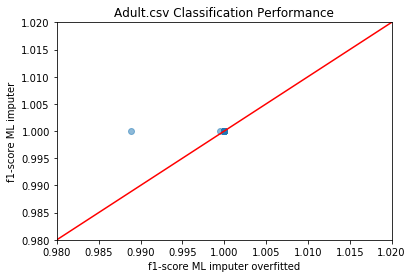

In [36]:
f1_ml = [y['f1'] for x in ml_imputer_results for y in ml_imputer_results[x] if 'f1' in y.keys()]
f1_overfit = [y['f1'] for x in overfitted_ml_imputer_results for y in overfitted_ml_imputer_results[x] if 'f1' in y.keys()]
fig, ax = plt.subplots()
sc = plt.scatter(f1_overfit, 
                 f1_ml, 
                 alpha=0.5)
plt.plot(np.linspace(-2, 2), np.linspace(-2, 2), c='red')
ax.set(title='Adult.csv Classification Performance',
      xlabel = 'f1-score ML imputer overfitted',
      ylabel = 'f1-score ML imputer',
      xlim = [0.98, 1.02],
      ylim  = [0.98, 1.02])

Spannendes Ergebnis - der overfittete ml_imputer legt auf den FDs eine aehnliche Performance hin wie der korrekt trainierte ml_imputer. Vielleicht ist das Overfitten ja wirklich genau das, was die FD-Definition von Haus aus mitbringt?

## Run ml_imputer on randomly generated dependencies

In [53]:
no_dependencies = 10
random_dependencies = fd_imputer.random_dependency_generator(list(df_test.columns), no_dependencies)

In [54]:
random_dependencies

{0: [[5, 11]],
 1: [[6, 11]],
 8: [[0, 1, 2, 4, 5, 6, 10, 11, 13, 14, 15], [4, 12, 13]],
 2: [[5]],
 13: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15]],
 4: [[5, 8, 11, 13]],
 6: [[0, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15],
  [0, 1, 2, 5, 7, 8, 10, 11, 15]],
 7: [[3, 9, 12, 14]]}

In [60]:
pickle.dump(random_dependencies, open( ADULT_RANDOM_FD_PATH, "wb"))

In [61]:
pickle.load(open(ADULT_RANDOM_FD_PATH, 'rb'))

{0: [[5, 11]],
 1: [[6, 11]],
 8: [[0, 1, 2, 4, 5, 6, 10, 11, 13, 14, 15], [4, 12, 13]],
 2: [[5]],
 13: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15]],
 4: [[5, 8, 11, 13]],
 6: [[0, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15],
  [0, 1, 2, 5, 7, 8, 10, 11, 15]],
 7: [[3, 9, 12, 14]]}

### ML_imputer on random dependencies

In [ ]:
ml_imputer_results_random = fd_imputer.run_ml_imputer_on_fd_set(df_train,
                                                        df_validate,
                                                        df_test,
                                                        random_dependencies,
                                                        continuous)

In [ ]:
overfitted_ml_imputer_results_random = fd_imputer.run_ml_imputer_on_fd_set(df_train,
                                                        df_train,
                                                        df_test,
                                                        random_dependencies,
                                                        continuous)

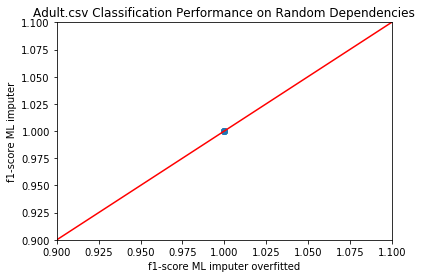

In [64]:
f1_ml_random = [y['f1'] for x in ml_imputer_results_random for y in ml_imputer_results_random[x] if 'f1' in y.keys()]
f1_overfit_random = [y['f1'] for x in overfitted_ml_imputer_results_random for y in overfitted_ml_imputer_results_random[x] if 'f1' in y.keys()]
fig, ax = plt.subplots()
sc = plt.scatter(f1_overfit_random, 
                 f1_ml_random, 
                 alpha=0.5)
plt.plot(np.linspace(-2, 2), np.linspace(-2, 2), c='red')
ax.set(title='Adult.csv Classification Performance on Random Dependencies',
      xlabel = 'f1-score ML imputer overfitted',
      ylabel = 'f1-score ML imputer',
      xlim = [0.9, 1.1],
      ylim  = [0.9, 1.1])
fig.savefig('img/ml-random-dependency-classification.png', transparent=False,
           dpi=320, bbox_inches='tight')

Das ist überraschend. Auf keinen Fall ist es möglich, dass ein overfitteter Classifier für **alle** Dependencies den gleichen f1-score wie ein korrekt trainierter Classifier zurückgibt. Ich schätze, dass der Aufruf
```
run_ml_imputer_on_fd_set(df_train, df_train, df_test, ...)
```
dazu führt, dass datawig eine k-fold Crossvalidation auf df_test ausführt, anstatt zu overfitten.
Hast du eine Idee, wie ich Datawig zum overfitten bringen kann? Vielleicht ein leeres df mit den `column_names` von `adult.csv` als `df_validate` übergeben?